# TP 1: Visualisation of Sleep and EEG data from the Dreem Headband

This first tutorial will guide you through the visualisation of EEG and accelerometer data from the Dreem Headband.


## A primer on Sleep, EEG and sleep classification:

Definition of Sleep according to wikipedia:
> Sleep is a naturally recurring state of mind and body, characterized by altered consciousness, relatively inhibited sensory activity, reduced muscle activity and inhibition of nearly all voluntary muscles during rapid eye movement (REM) sleep,[1] and reduced interactions with surroundings.[2] It is distinguished from wakefulness by a decreased ability to react to stimuli, but more reactive than a coma or disorders of consciousness, with sleep displaying different, active brain patterns.

> Sleep occurs in repeating periods, in which the body alternates between two distinct modes: REM sleep and non-REM sleep. Although REM stands for "rapid eye movement", this mode of sleep has many other aspects, including virtual paralysis of the body. A well-known feature of sleep is the dream, an experience typically recounted in narrative form, which resembles waking life while in progress, but which usually can later be distinguished as fantasy. During sleep, most of the body's systems are in an anabolic state, helping to restore the immune, nervous, skeletal, and muscular systems;[3] these are vital processes that maintain mood, memory, and cognitive function, and play a large role in the function of the endocrine and immune systems.[4] The internal circadian clock promotes sleep daily at night. The diverse purposes and mechanisms of sleep are the subject of substantial ongoing research.[5] Sleep is a highly conserved behavior across animal evolution.[6] 

During sleep the body goes through five sleep stages, WAKE, N1 and N2 (light sleep), N3 (Deep Sleep) and Rapid Eyes Movement (or REM/paradoxical sleep).
Each stage corresponds to specifici patterns which can be seen on physiological data like EEG (Brain activity), EMG (muscle activity), EOG (Eyes movement) or even ECG (Cardiac activity).
You can find more details on each of the Sleep Stage there: https://opentext.wsu.edu/psych105/chapter/stages-of-sleep/

Each sleep stage is defined over a period of 30 seconds which we will call a Sleep Epoch. A night of 8 hours contains 960 sleep epochs.
The classification of the sleep stage of a night is usually done manually, the process is long (around 1h), requires trained sleep experts and is subject to inter-rater variability.


**Though sleep scoring rules are more complex. Each sleep stage can be described by its frequency content:**
- Wake: Proeminence of the alpha rythm, fast rythm between 8 and 12 Hz (Subject awake with eyes closed).
- N1: Rythm between 4 and 7Hz, slow eyes movement
- N2: Appartition of spindles, short burst (0.5s - 2 s) between 11 ans 16Hz and K-complexes
- N3 (Slow wave sleep): Majority of slow waves (between 0.5 to 4Hz)
- REM sleep: Sawtooth waves (2 to 6Hz), and rolling symetriceal eyes movement

<img src="https://www.ncbi.nlm.nih.gov/pmc/articles/instance/7751170/bin/zsaa097_fig1.jpg">


The Dreem Headband provides an automated sleep staging algorithm based on its sensors:
- 5 EEG derivations sampled at 250Hz
- 3 Accelerometers derivations sampled at 50Hz

The goal of these TPs are to emulate what we do at Dreem on a subsample of labelled data.


## Setting up the environment
- The data are already hosted on Kaggle so you will have access to them from the notebook
- We install yasa and mne which are two toolboxes to work with EEG data

In [12]:
pip install yasa mne

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
cd "C:\Users\Piquant Mark\Desktop\CENTRALE\3A\MMF\SD9\Machine_Learning\Kaagle\input\automated-sleep-staging-beacon-biosignals-2023-2024"

C:\Users\Piquant Mark\Desktop\CENTRALE\3A\MMF\SD9\Machine_Learning\Kaagle\input\automated-sleep-staging-beacon-biosignals-2023-2024


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, confusion_matrix
import matplotlib.pyplot as plt
import json
import yasa
import os
import numpy as np

In the folder Dreem_Master_Bin/sample/sample, you can find several .npy file containing EEG, accelerometer data and the hypnogram of a record .

The EEG data are sampled at 250 HZ and the accelerometer data at 50hz, the hypnogram is the succession of the sleep stages for this record.


Let's look at it !


## Loading the Data

The data can be loaded with the numpy library, let's have a quick look at their duration and format.

In [15]:
eeg = np.load('sample/sample/f7_O2.npy') 
print(eeg)
print('EEG duration', eeg.shape[0] / 250)

[   166.7419     347.28906    460.7966  ... -20320.445   -13659.48
  -2696.672  ]
EEG duration 25845.94


In [ ]:
accelerometer_x = np.load('sample/sample/accelerometer_x.npy') 
print(accelerometer_x.shape())
print('Accelerometer duration', accelerometer_x.shape[0] / 50)

[0.286438   0.28588867 0.2849121  ... 0.09423828 0.09423828 0.09436035]
Accelerometer duration 25845.94


The hypnogram is encoded as a sequence of integer with the following matching:
- 0: WAKE
- 1: N1
- 2: N2
- 3: N3/DEEP SLEEP
- 4: REM

In [17]:
hypnogram = np.array(json.load(open('sample/sample/hypnogram.json')))
print(hypnogram)
print('Hypnogram duration', hypnogram.shape[0])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 1 1 1 1 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 1 1 2 0 0 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 4 4 4 4 4 4 4 4 4 4 0 1 4 4 4 4 4 0 1 4 4 1 4 4 1
 4 4 4 4 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 0 0 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 

## Visualisation of RAW EEG and hypnogram data

Let's have a look at eeg data at a night-level and at an epoch level.

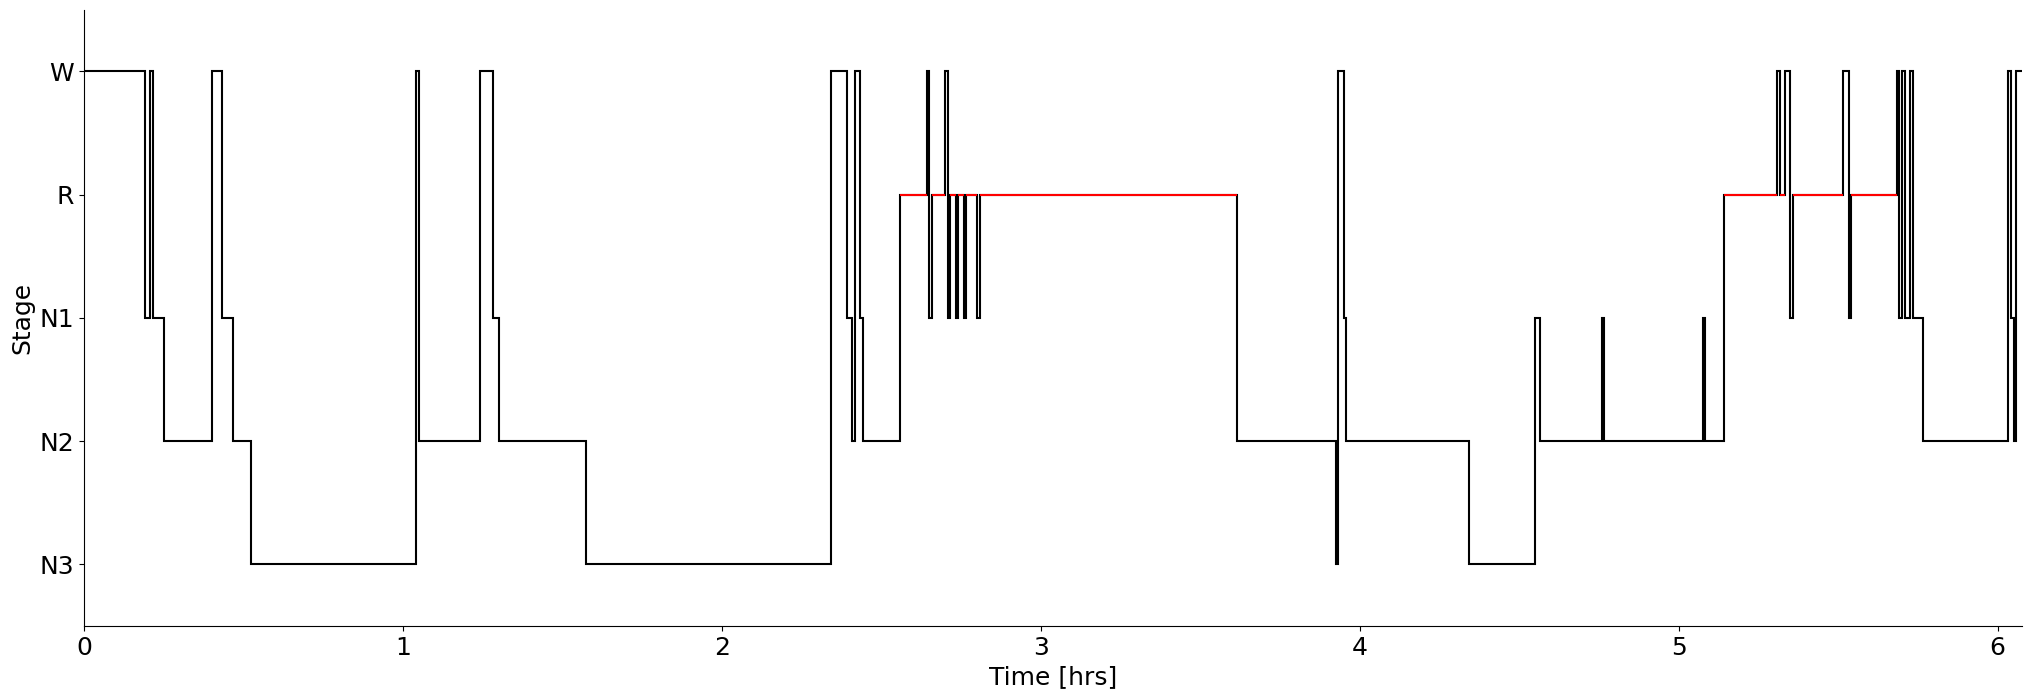

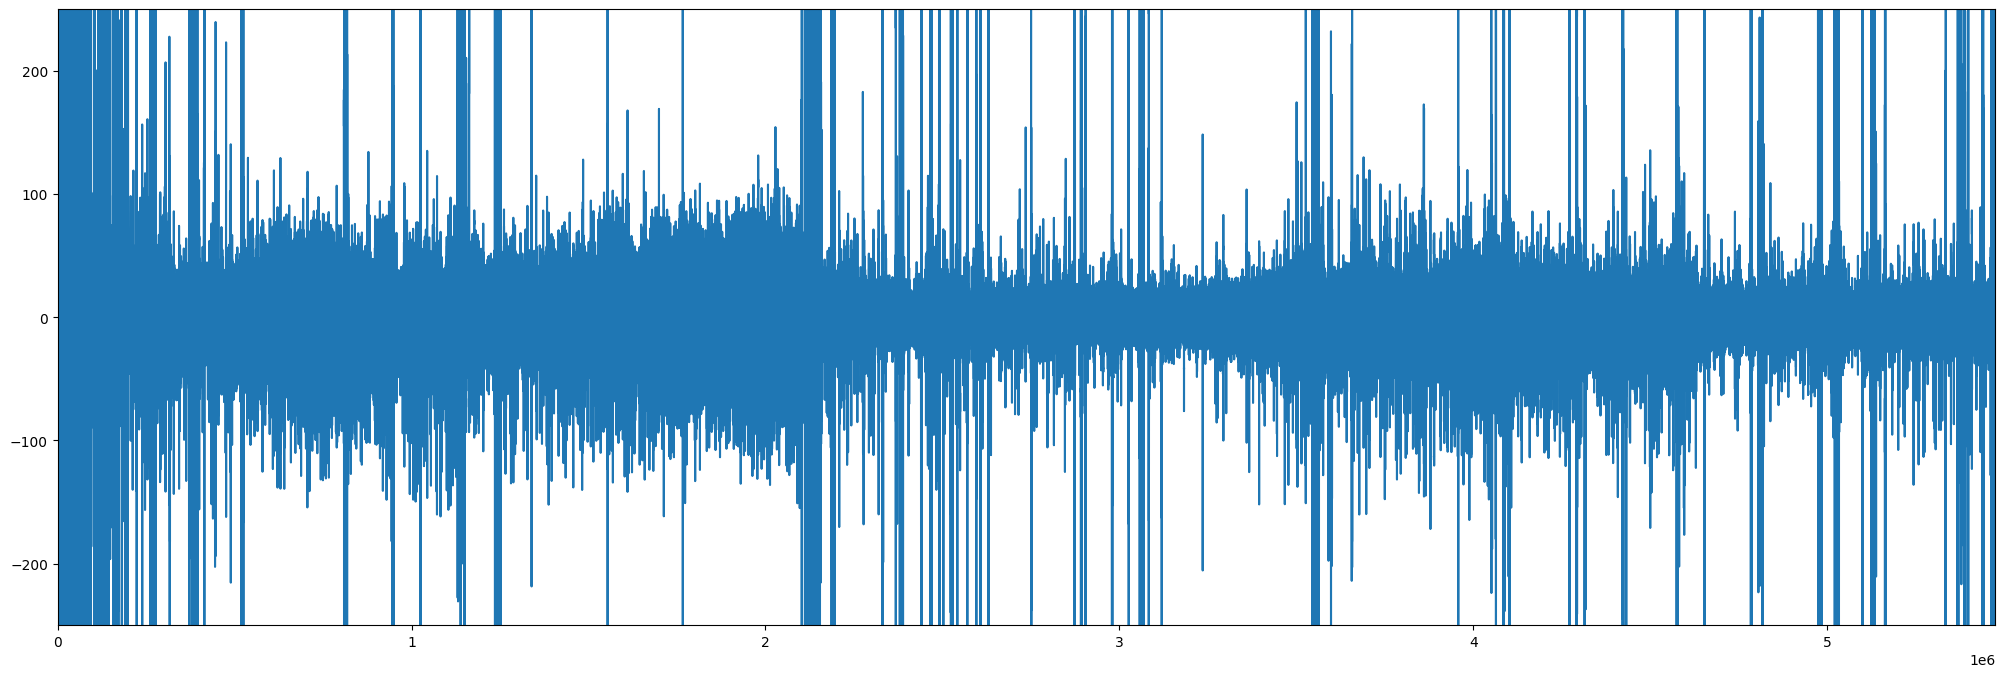

In [18]:
# let's load the first record

n_epoch = 730
eeg = np.load('sample/sample/f7_O2.npy')[:n_epoch * 250 * 30]
hypnogram = np.array(json.load(open('sample/sample/hypnogram.json')))[:n_epoch]

# plot it !

plt.figure(figsize=(25, 8))
yasa.plot_hypnogram(hypnogram)
plt.figure(figsize=(25, 8))
plt.plot(eeg)
plt.ylim([-250, 250])
plt.xlim(0,eeg.shape[0])
plt.show()

### Visualisation of 30 seconds of EEG
Let's plot some sleep epochs which are typical of their various sleep stages

REM sleep is distinguishable with its steady EEG and eyes movement which can be seen when looking at Frontal-occipital vs frontal-frontal derivation.

In [19]:
def plot_eeg_epoch(data,epoch_index,title):
    plt.figure(figsize=(25, 8))
    plt.title(title)
    for eeg in data:
        plt.plot(np.arange(0,250 * 30) / 250,eeg[250 * epoch_index * 30:250 * (epoch_index + 1) * 30])
    plt.ylim([-200, 200])
    plt.xlim(0,30)
    plt.show()
    

#### During Wake epoch alpha waves are clearly visible on the F-O derivation.

[Alpha waves definition](https://www.sleepfoundation.org/how-sleep-works/alpha-waves-and-sleep)

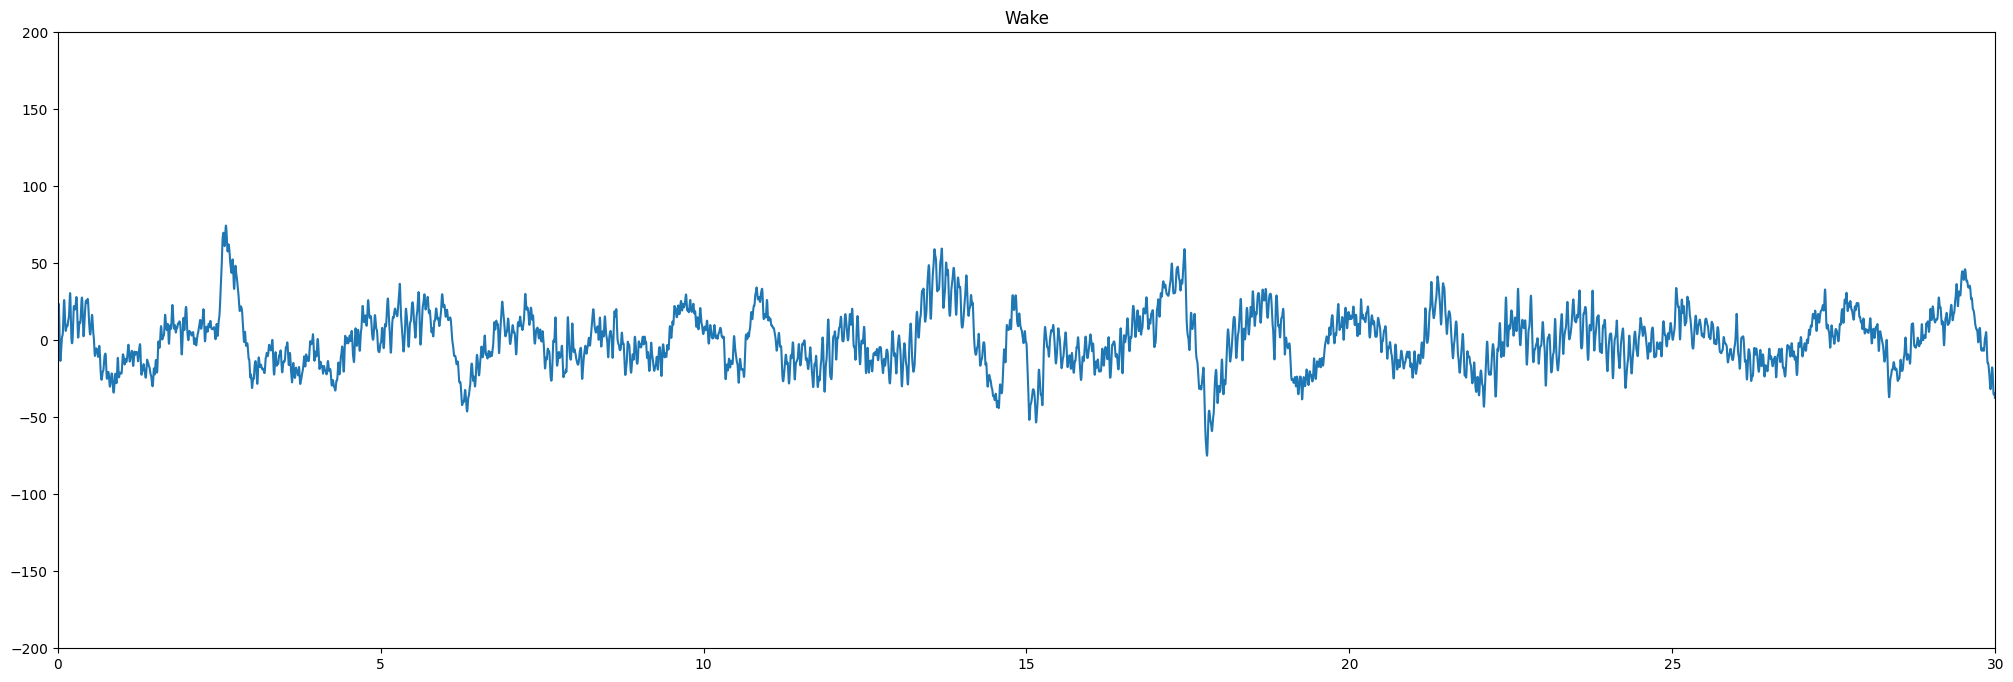

In [20]:
# let's load the first record
eeg = np.load('sample/sample/f7_O2.npy')
eeg_frontal = np.load('sample/sample/f8_f7.npy')
# plot it !
plot_eeg_epoch([eeg],20,'Wake') # 





### During N3/Deep Sleep we can see slow waves.
[Slow Wave Sleep](https://en.wikipedia.org/wiki/Slow-wave_sleep)

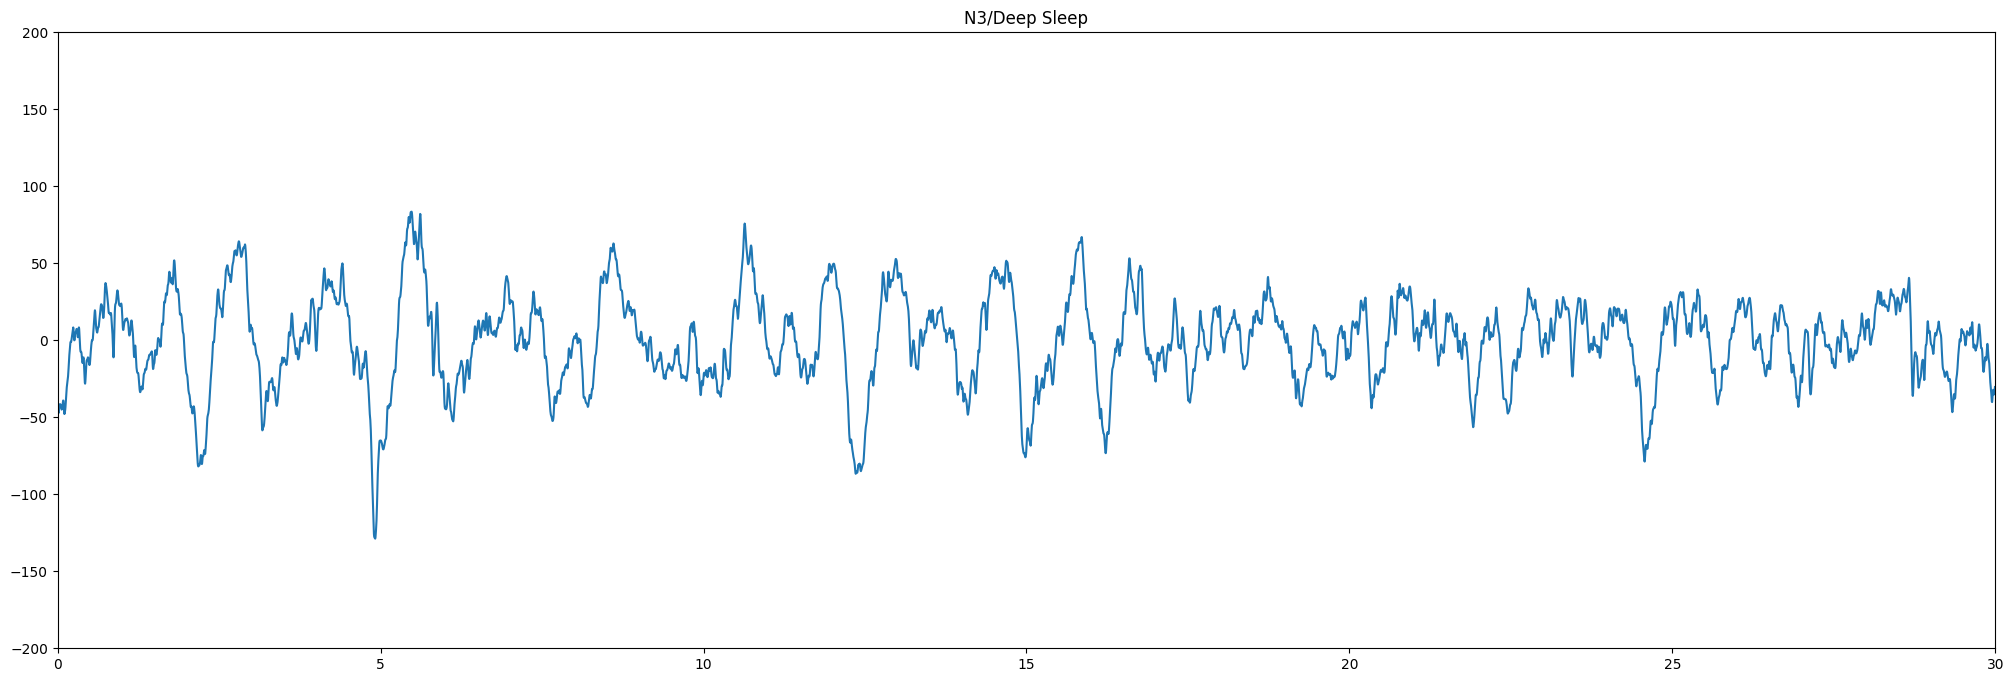

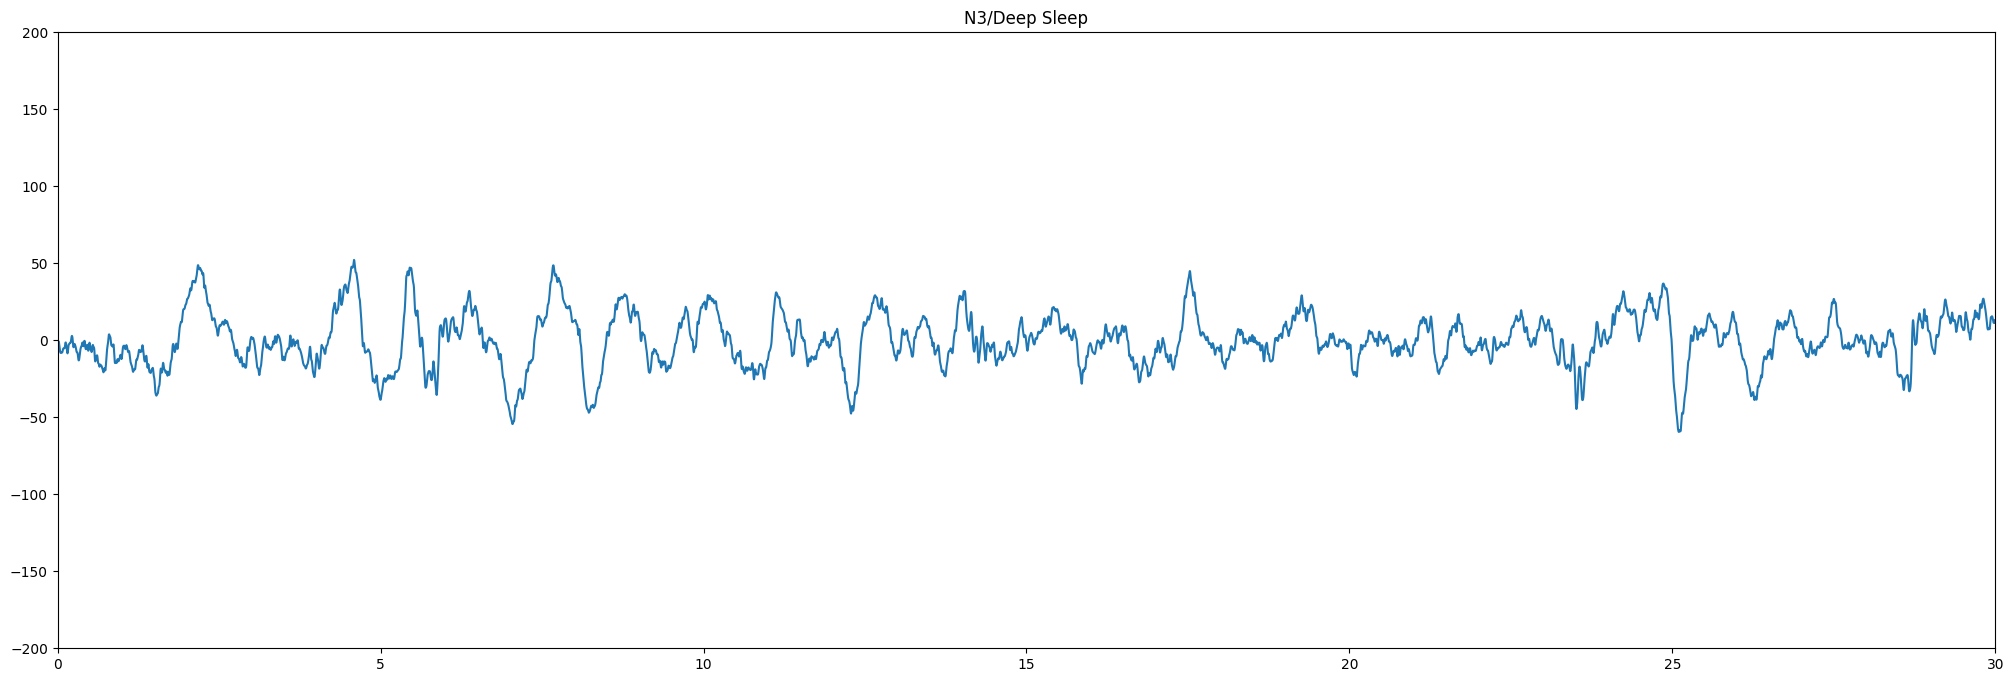

In [21]:
plot_eeg_epoch([eeg],100,'N3/Deep Sleep')

plot_eeg_epoch([eeg_frontal],100,'N3/Deep Sleep')


#### REM Sleep is characterized by eyes movement on the Dreem Headband, they can been seen with inverted voltage on the F-O and F-F derivations.
[REM Sleep](https://en.wikipedia.org/wiki/Rapid_eye_movement_sleep)

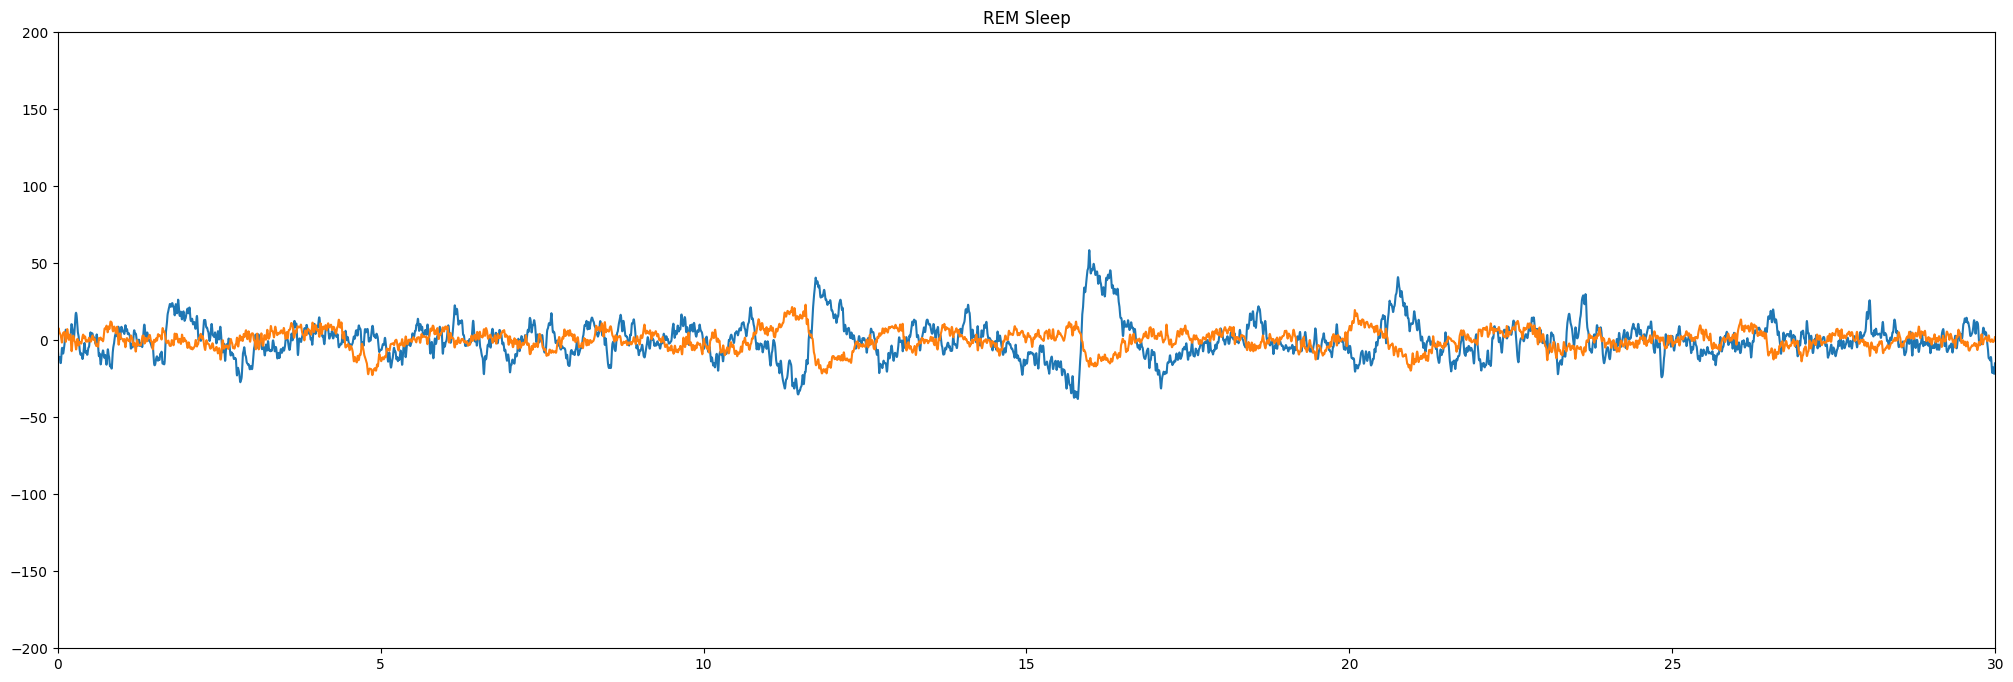

In [22]:
plot_eeg_epoch([eeg,eeg_frontal],420,'REM Sleep')


### During N2, sleep spindles are more visible on the Frontal-frontal derivation

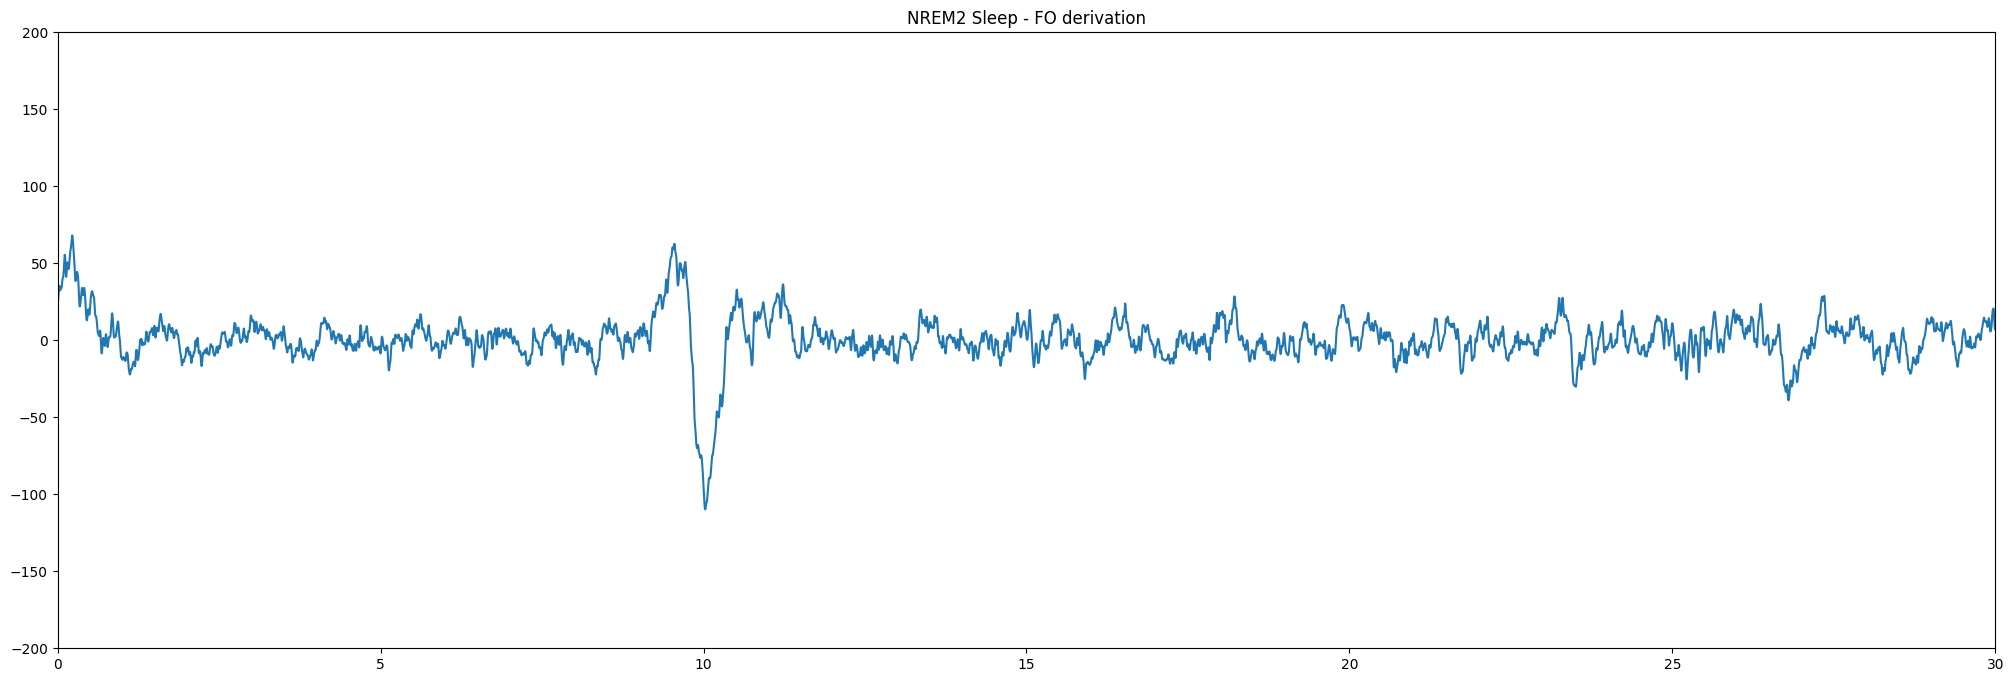

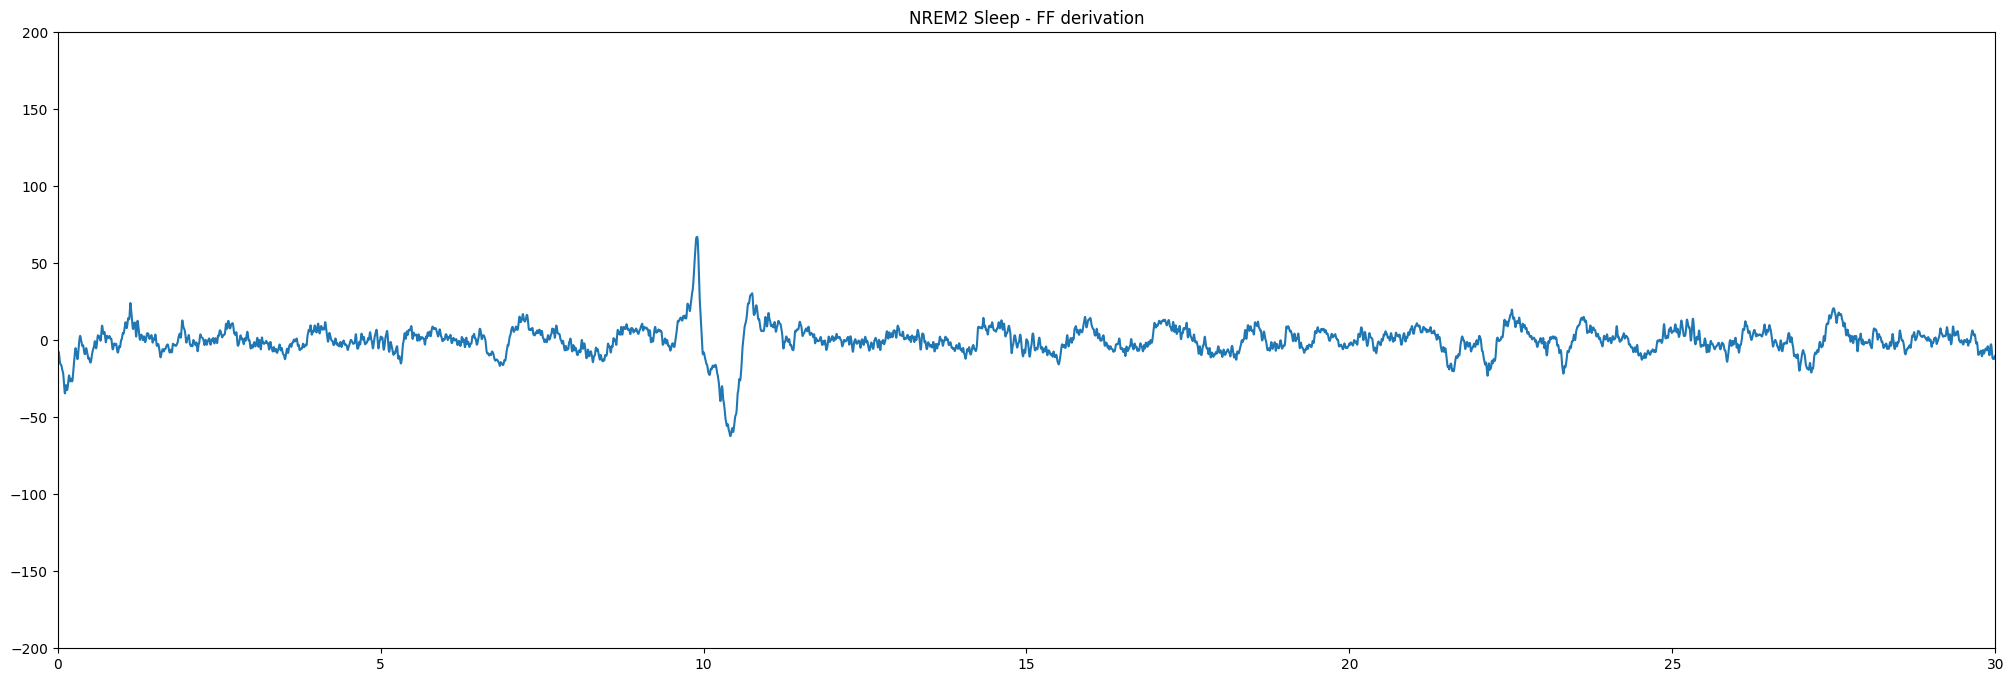

In [23]:
plot_eeg_epoch([eeg],703,'NREM2 Sleep - FO derivation')
plot_eeg_epoch([eeg_frontal],703,"NREM2 Sleep - FF derivation")



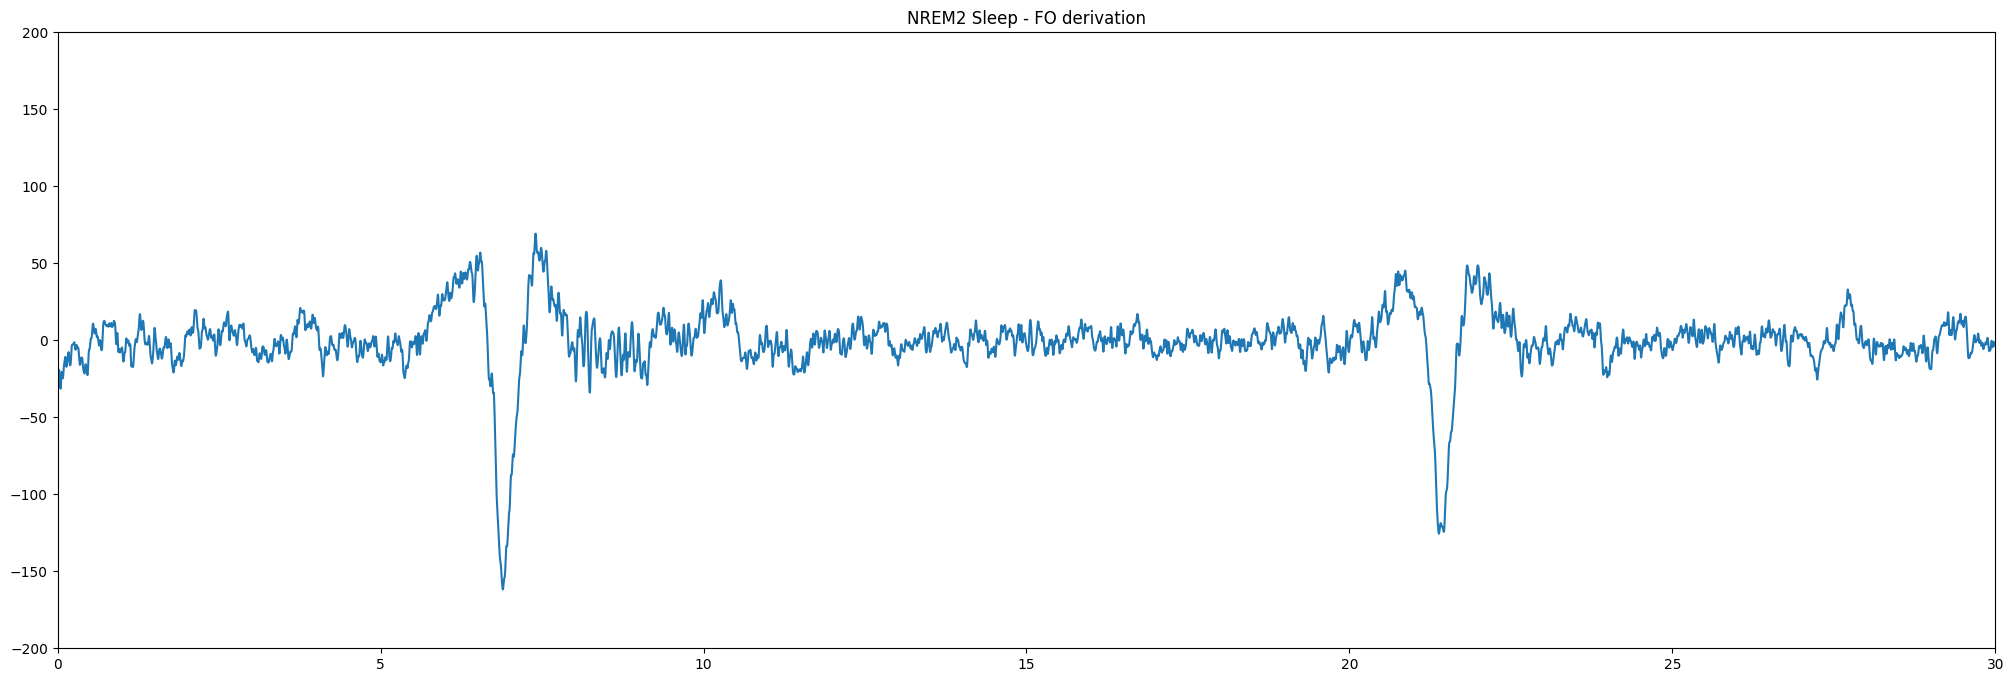

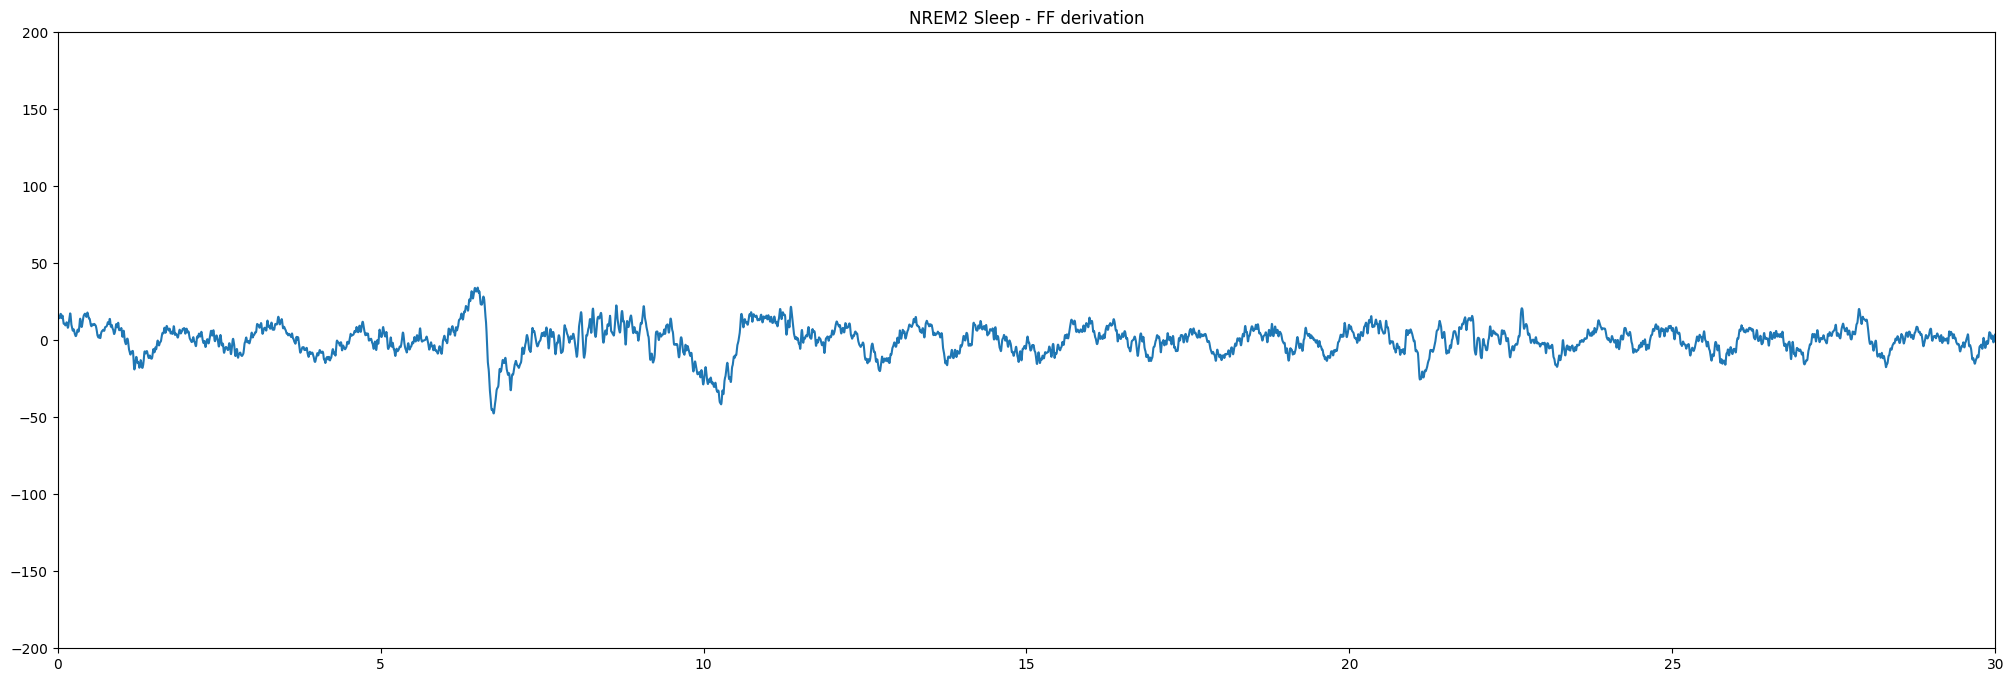

In [24]:
plot_eeg_epoch([eeg],144,'NREM2 Sleep - FO derivation')
plot_eeg_epoch([eeg_frontal],144,"NREM2 Sleep - FF derivation")



## Spectral analysis of EEG data


The EEG data can also be analysis using a time-frequency representation, some rythm and frequency bands are typical of specific sleep stages:
- Wake: Proeminence of the alpha rythm, fast rythm between 8 and 12 Hz (Subject awake with eyes closed).
- N1: Rythm between 4 and 7Hz, slow eyes movement
- N2: Appartition of spindles, short burst (0.5s - 2 s) between 11 ans 16Hz and K-complexes
- N3 (Slow wave sleep): Majority of slow waves (between 0.5 to 4Hz)
- REM sleep: Sawtooth waves (2 to 6Hz), and rolling symetriceal eyes movement

We will use multi-taper spectrogram from the yasa library to visualise the EEG rythms during the night.

You can find more information there: https://prerau.bwh.harvard.edu/multitaper/


### Visualisation of the spectrogram of the complete night
Red corresponds to frequencies more power while blue to frequencies with less power.

Text(0.5, 0.98, 'Spectrogram on F8-F7')

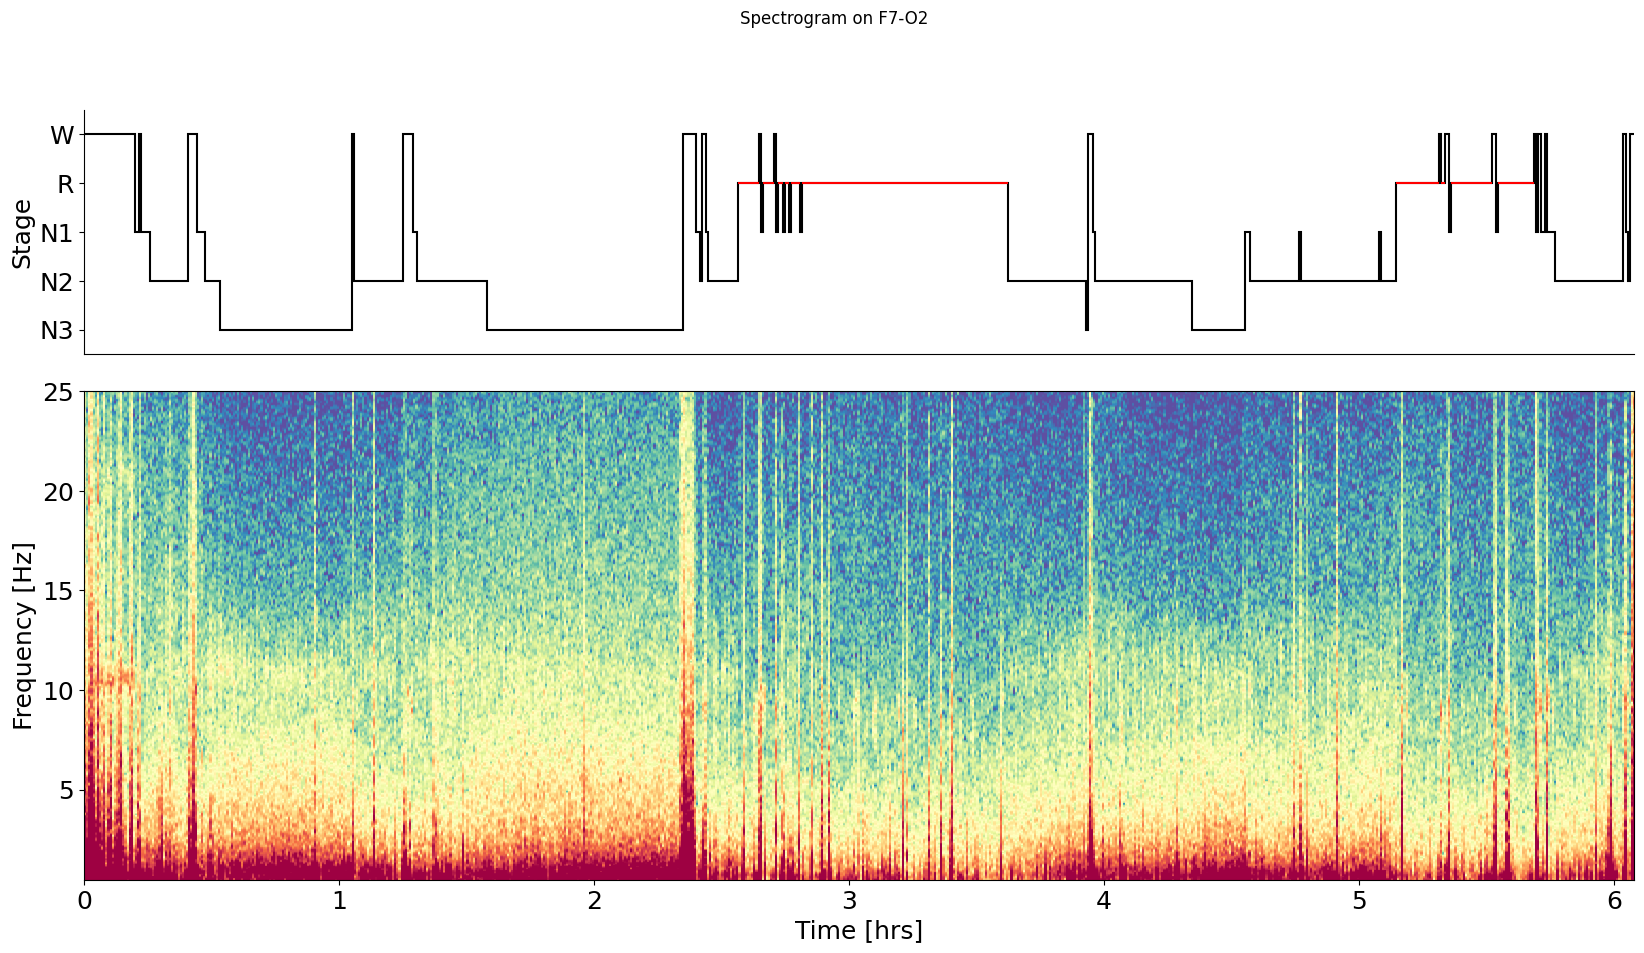

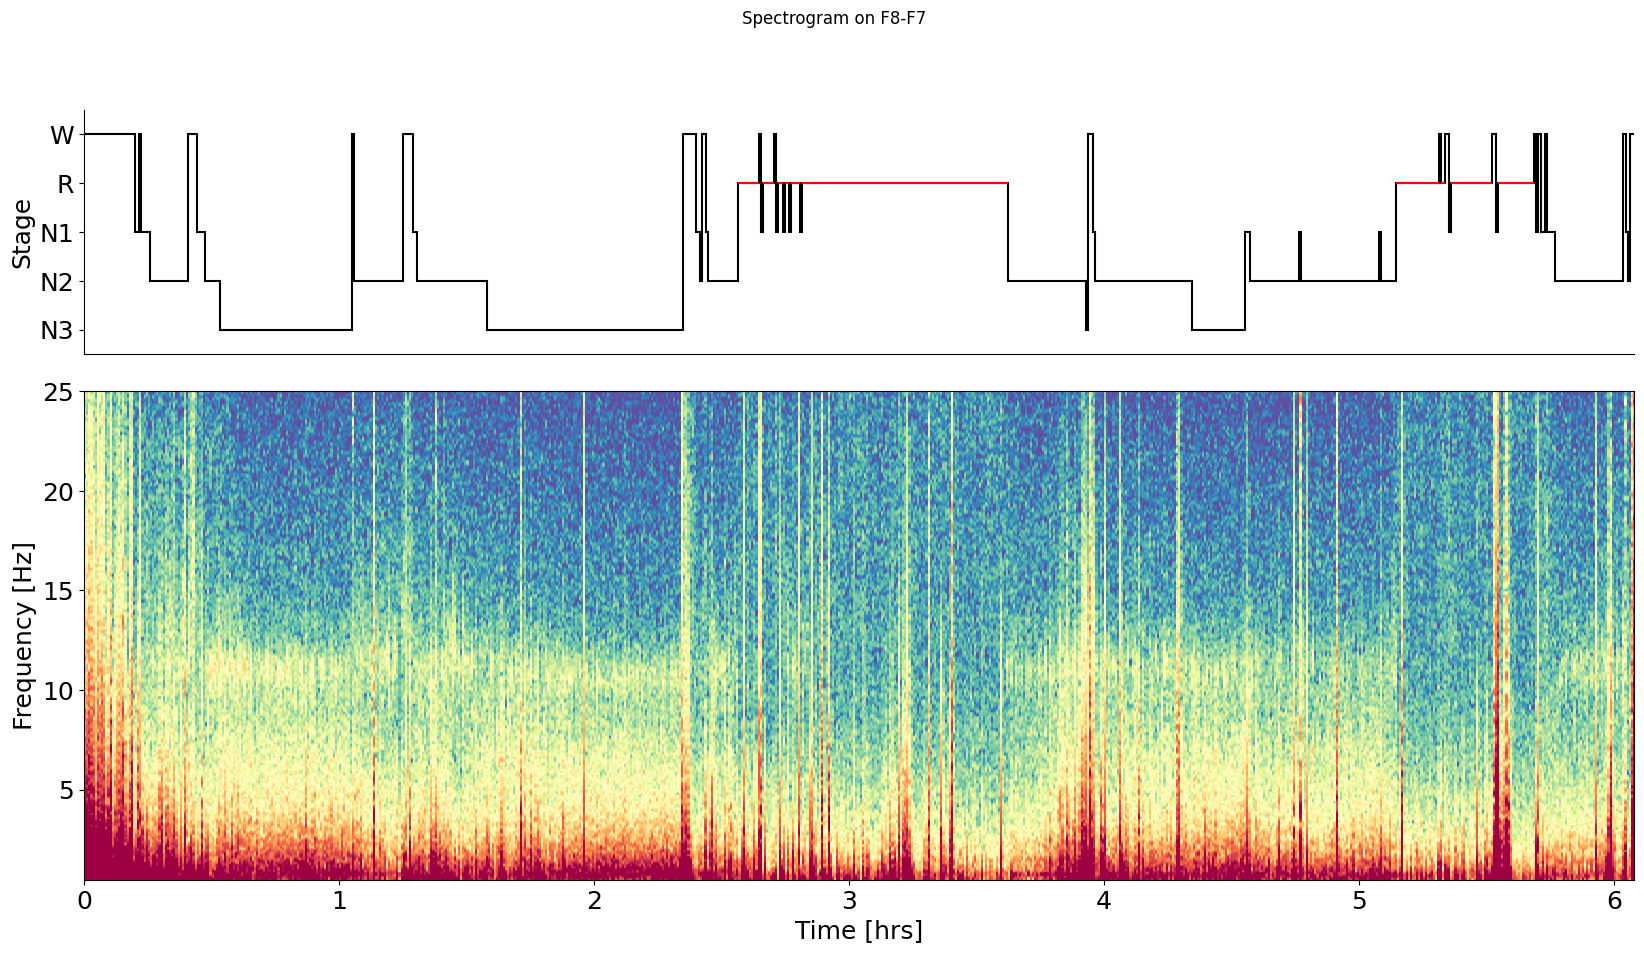

In [25]:
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = [20,10]
f = yasa.plot_spectrogram(np.clip(eeg[:n_epoch * 250 * 30],-200,200), 250,np.repeat(hypnogram[:n_epoch],250 * 30), cmap='Spectral_r',trimperc = 2.5)
f.set_figheight(10)
f.set_figwidth(20)
f.suptitle('Spectrogram on F7-O2')

f = yasa.plot_spectrogram(np.clip(eeg_frontal[:n_epoch * 250 * 30],-200,200), 250,np.repeat(hypnogram[:n_epoch],250 * 30), cmap='Spectral_r',trimperc = 2.5)
f.set_figheight(10)
f.set_figwidth(20)
f.suptitle("Spectrogram on F8-F7")

### Evolution of spectrogram during sleep stage transition

**The EEG power increases in the low-frequency band when the sleep stage change from REM to NREM sleep stages**

Text(0.5, 0.98, 'Spectrogram on F8-F7')

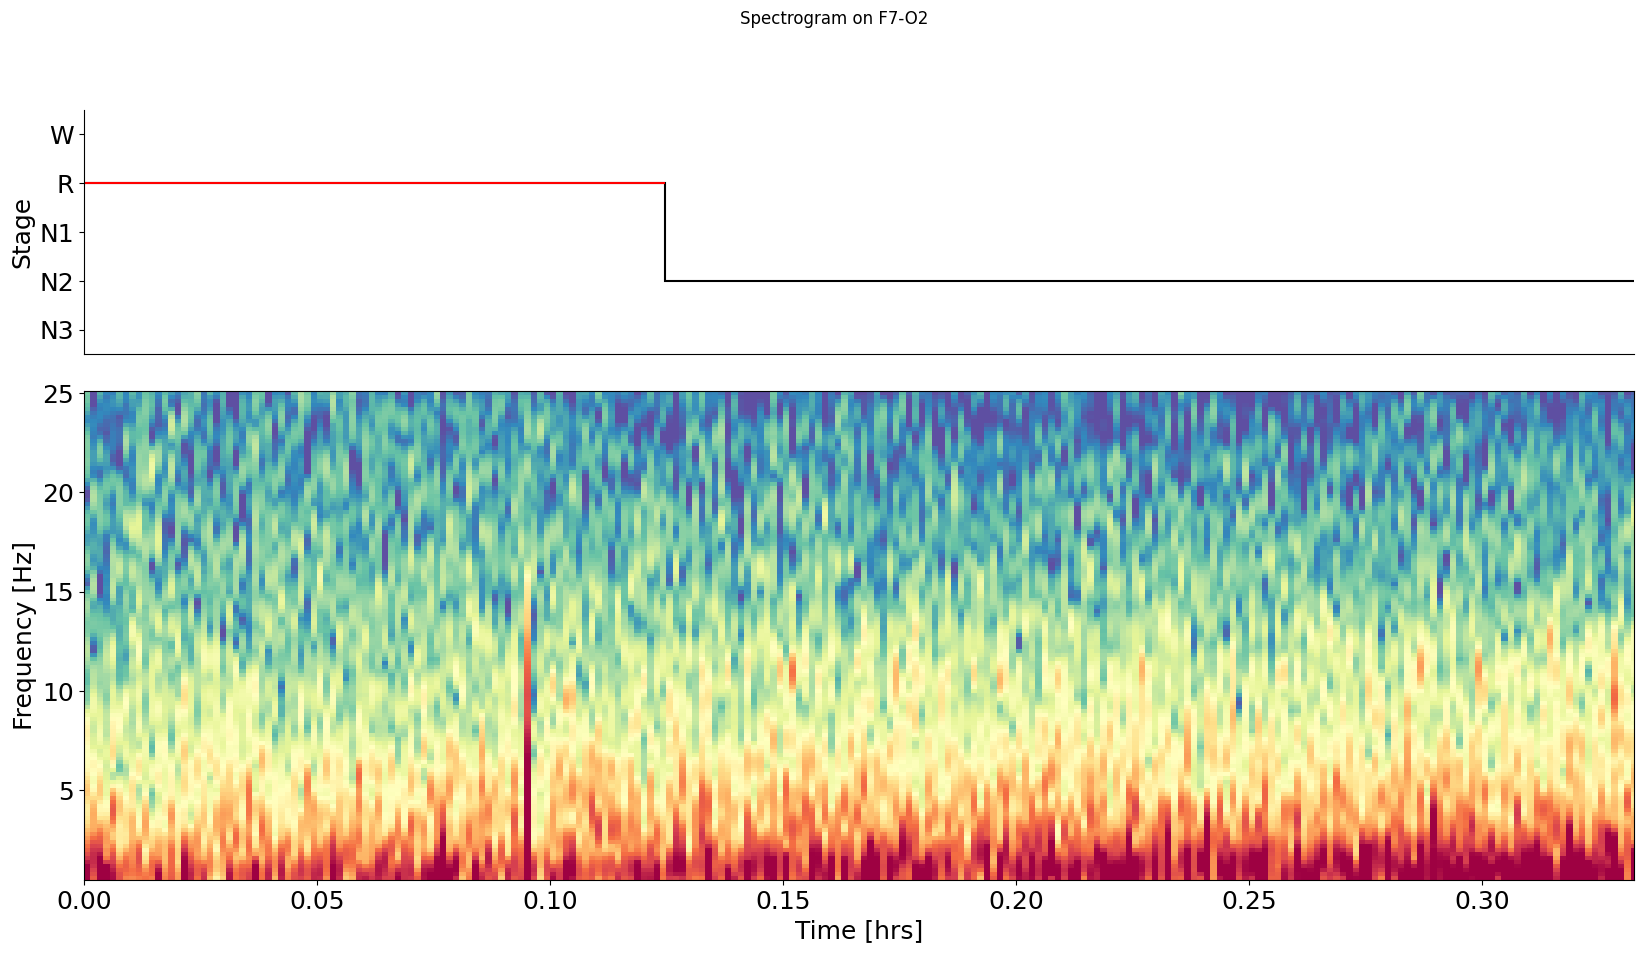

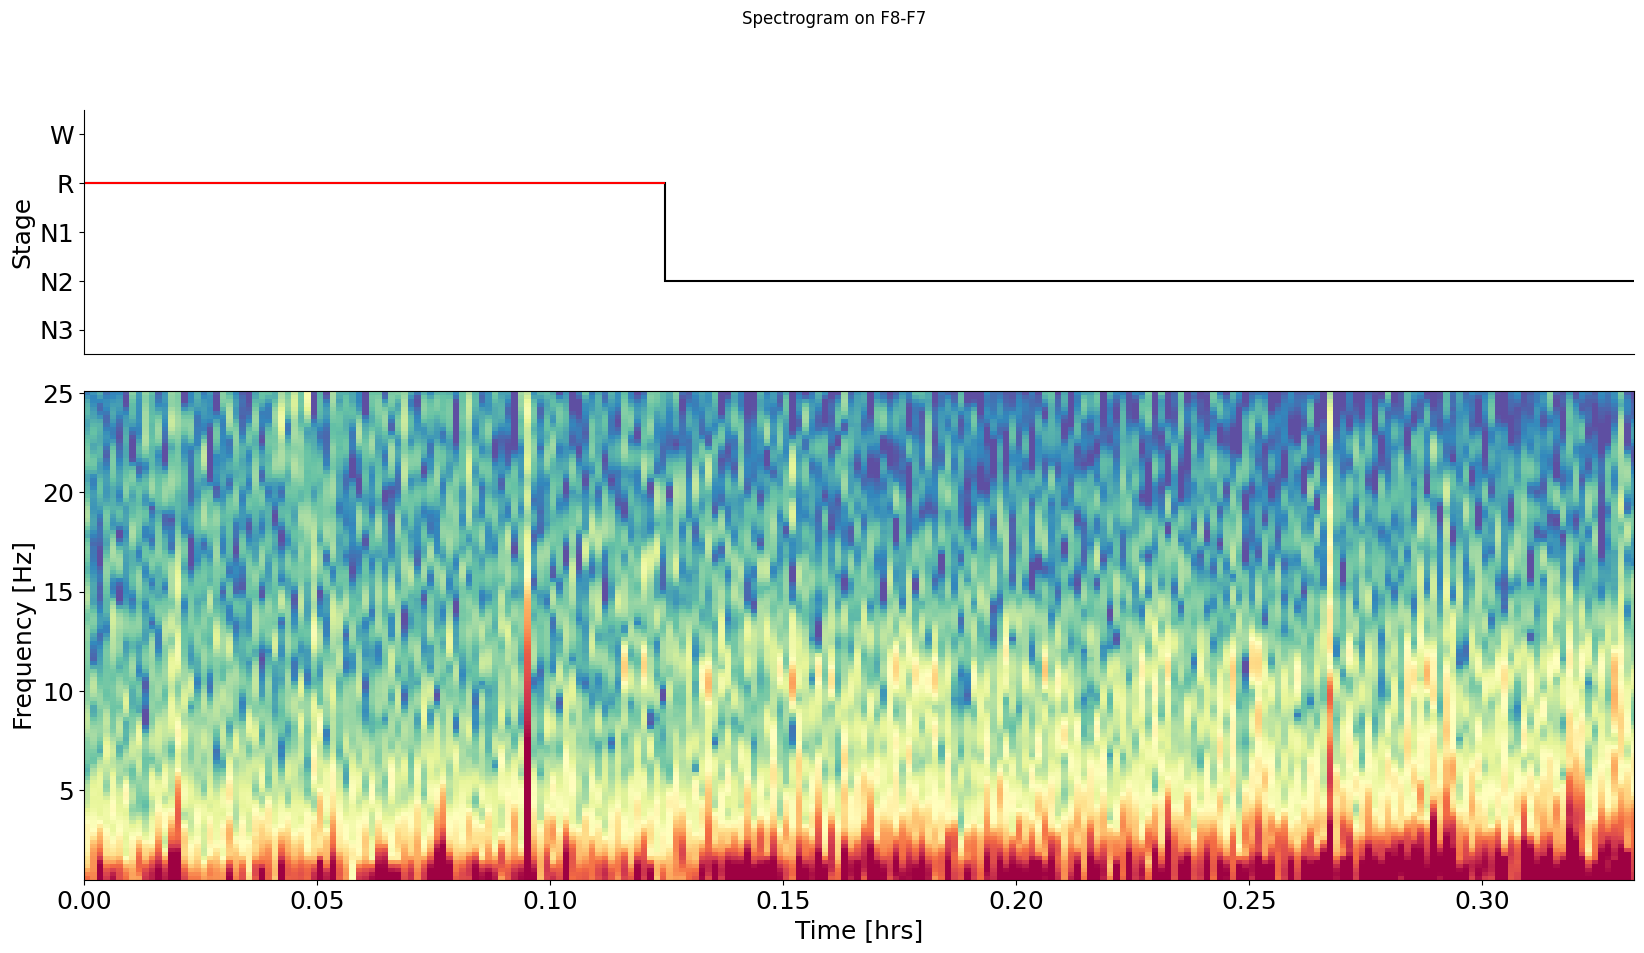

In [26]:
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = [20,10]
start,end = 420,460
start,end = int(start),int(end)

f = yasa.plot_spectrogram(np.clip(eeg[30 * 250 * start:30 * 250 * end],-200,200), 
                          250,
                          np.repeat(hypnogram[start:end],250 * 30), 
                          cmap='Spectral_r', win_sec = 5,trimperc = 2)
f.set_figheight(10)
f.set_figwidth(20)
f.suptitle('Spectrogram on F7-O2')


plt.rcParams["figure.figsize"] = [20,10]

f = yasa.plot_spectrogram(np.clip(eeg_frontal[30 * 250 * start:30 * 250 * end],-200,200), 
                          250,
                          np.repeat(hypnogram[start:end],250 * 30), 
                          cmap='Spectral_r', win_sec = 5,trimperc = 2)
f.set_figheight(10)
f.set_figwidth(20)
f.suptitle("Spectrogram on F8-F7")

**Below the subject alternate between wake and light sleep, we can seen alpha rythm emergin during wake and disapearing when the subjects get asleep again.**

Text(0.5, 0.98, 'Spectrogram on F8-F7')

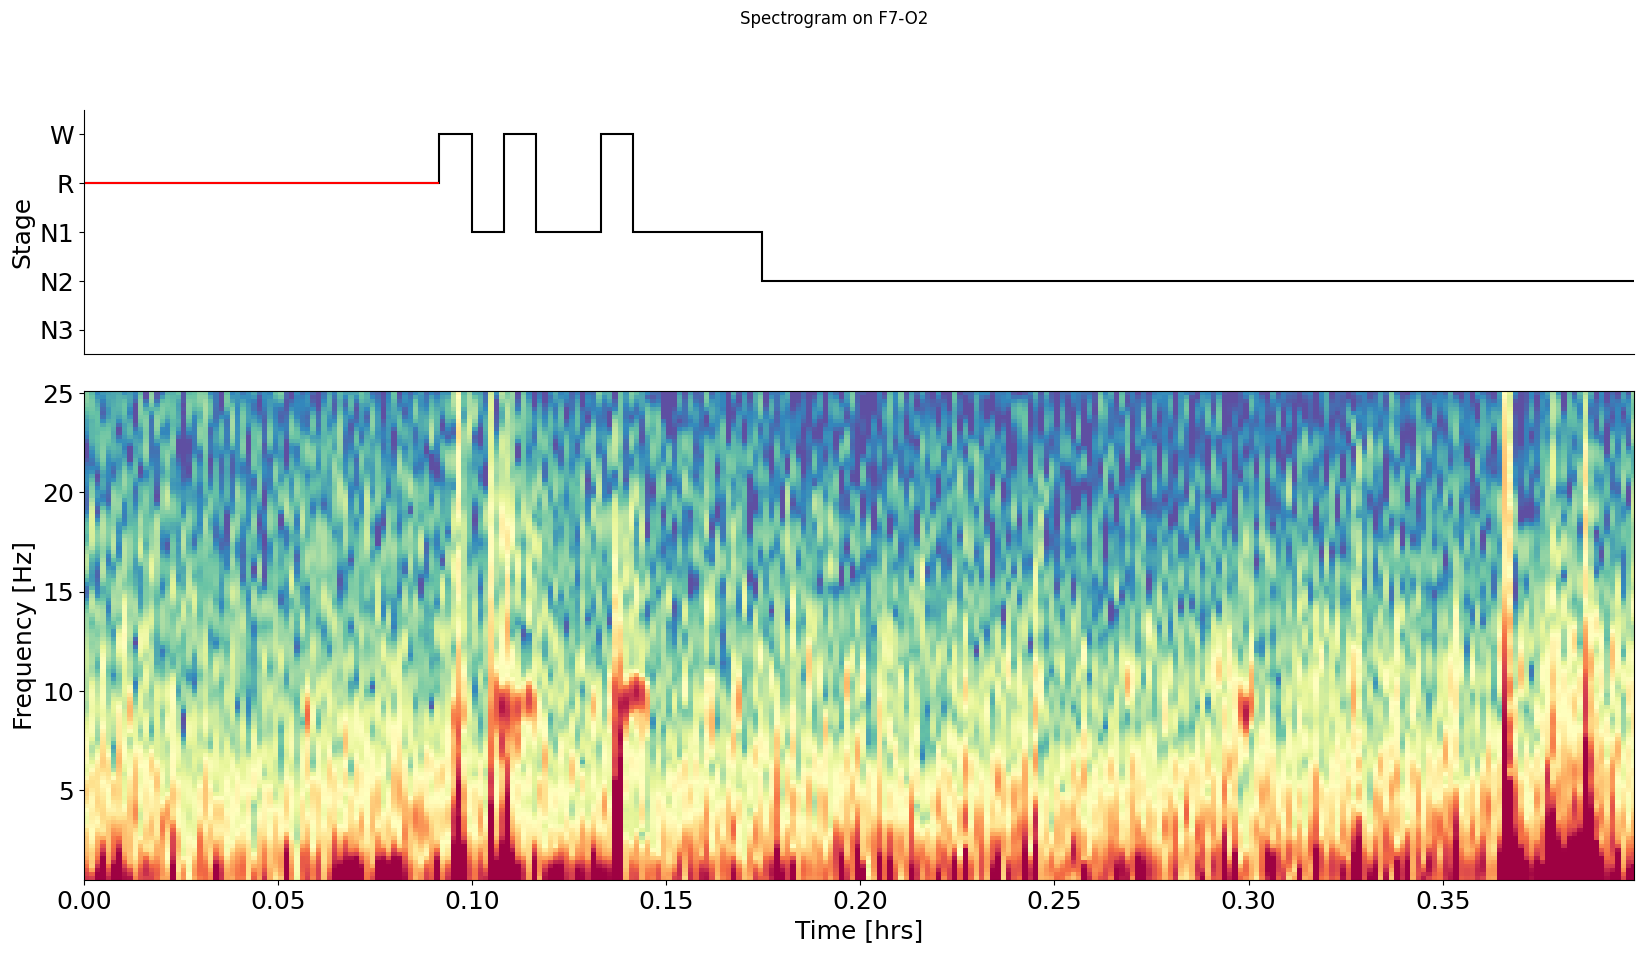

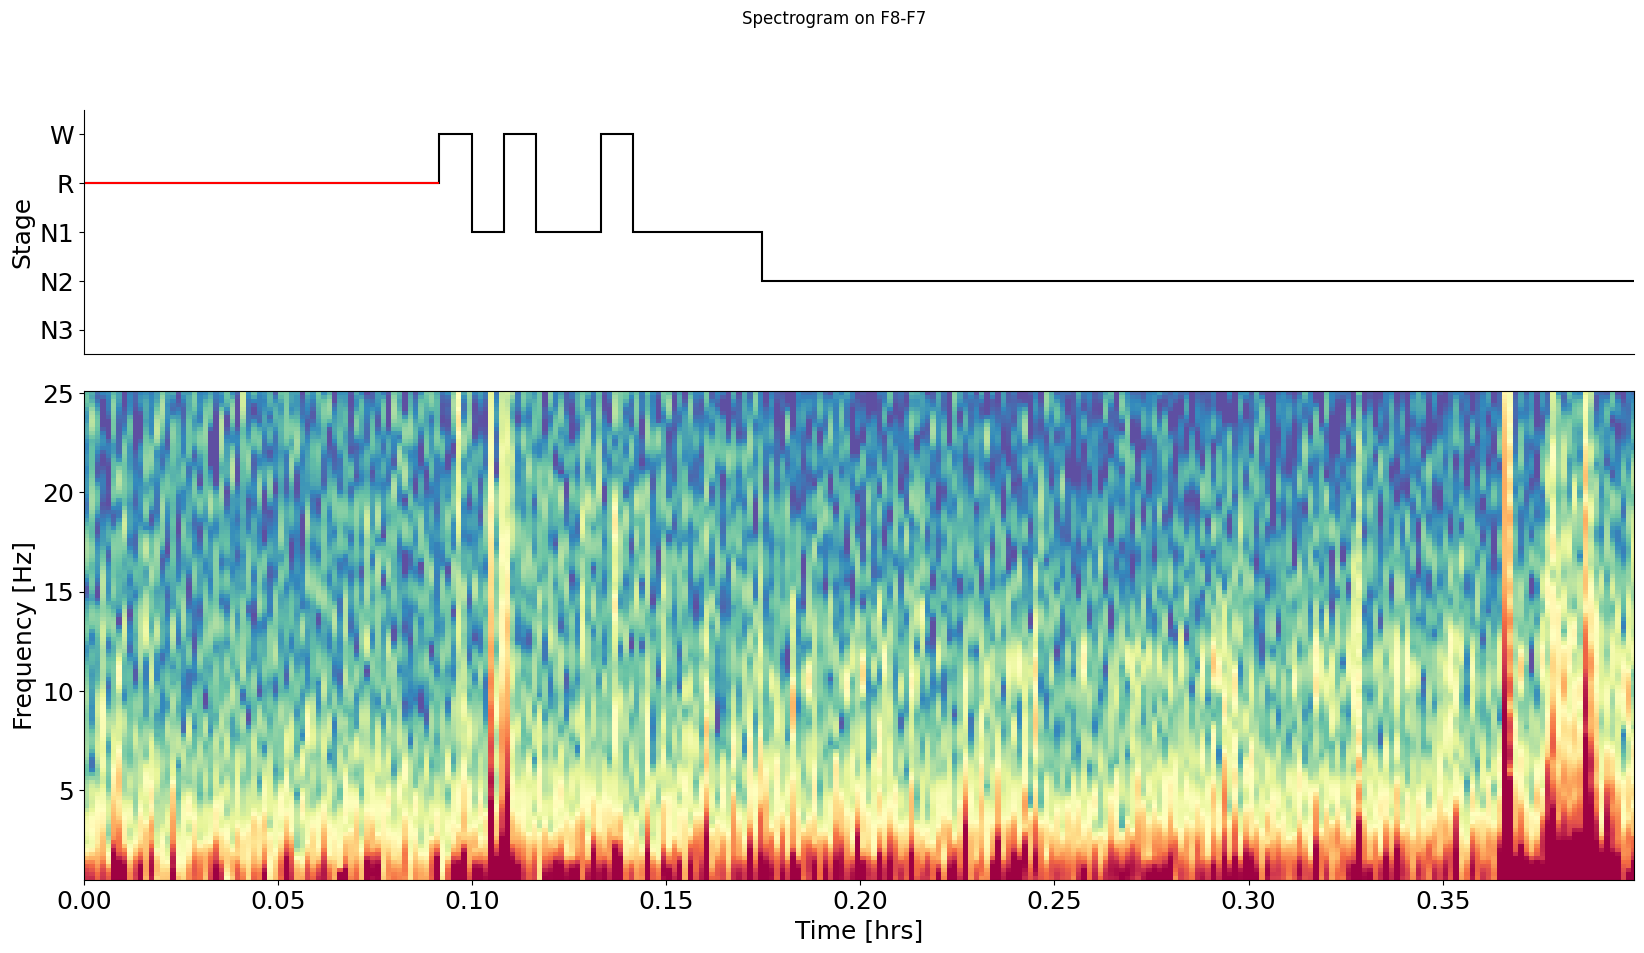

In [27]:
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = [20,10]
start,end = 120 * 5.6,120 * 6
start,end = int(start),int(end)

f = yasa.plot_spectrogram(np.clip(eeg[30 * 250 * start:30 * 250 * end],-200,200), 
                          250,
                          np.repeat(hypnogram[start:end],250 * 30), 
                          cmap='Spectral_r', win_sec = 5,trimperc = 2)
f.set_figheight(10)
f.set_figwidth(20)
f.suptitle('Spectrogram on F7-O2')


from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = [20,10]

start,end = int(start),int(end)
f = yasa.plot_spectrogram(np.clip(eeg_frontal[30 * 250 * start:30 * 250 * end],-200,200), 
                          250,
                          np.repeat(hypnogram[start:end],250 * 30), 
                          cmap='Spectral_r', win_sec = 5,trimperc = 2)
f.set_figheight(10)
f.set_figwidth(20)
f.suptitle("Spectrogram on F8-F7")

The unfiltered accelerometer data shows some position change by looking at the continuous component of the data.

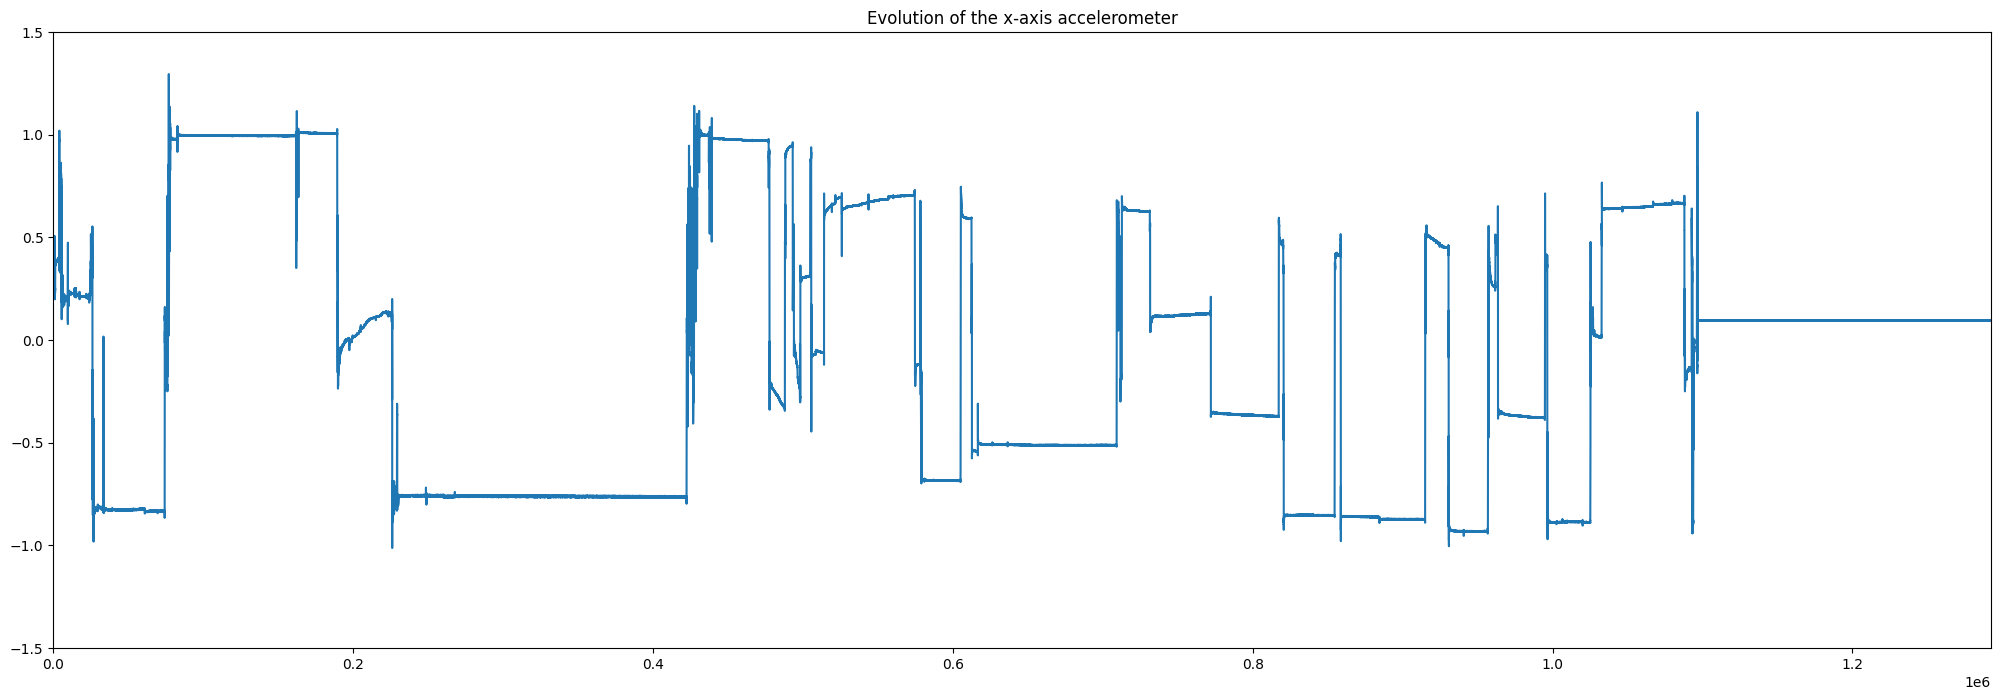

In [28]:

x = np.load('sample/sample/accelerometer_x.npy')

plt.figure(figsize=(25, 8))
plt.plot(x)
plt.ylim([-1.5, 1.5])
plt.xlim(0,x.shape[0])
plt.title('Evolution of the x-axis accelerometer')
plt.show()

Most of the ovements appear during wake stages, high power low frequency can be seen during some part of the record and correspond to respiration detection by the accelerometer.

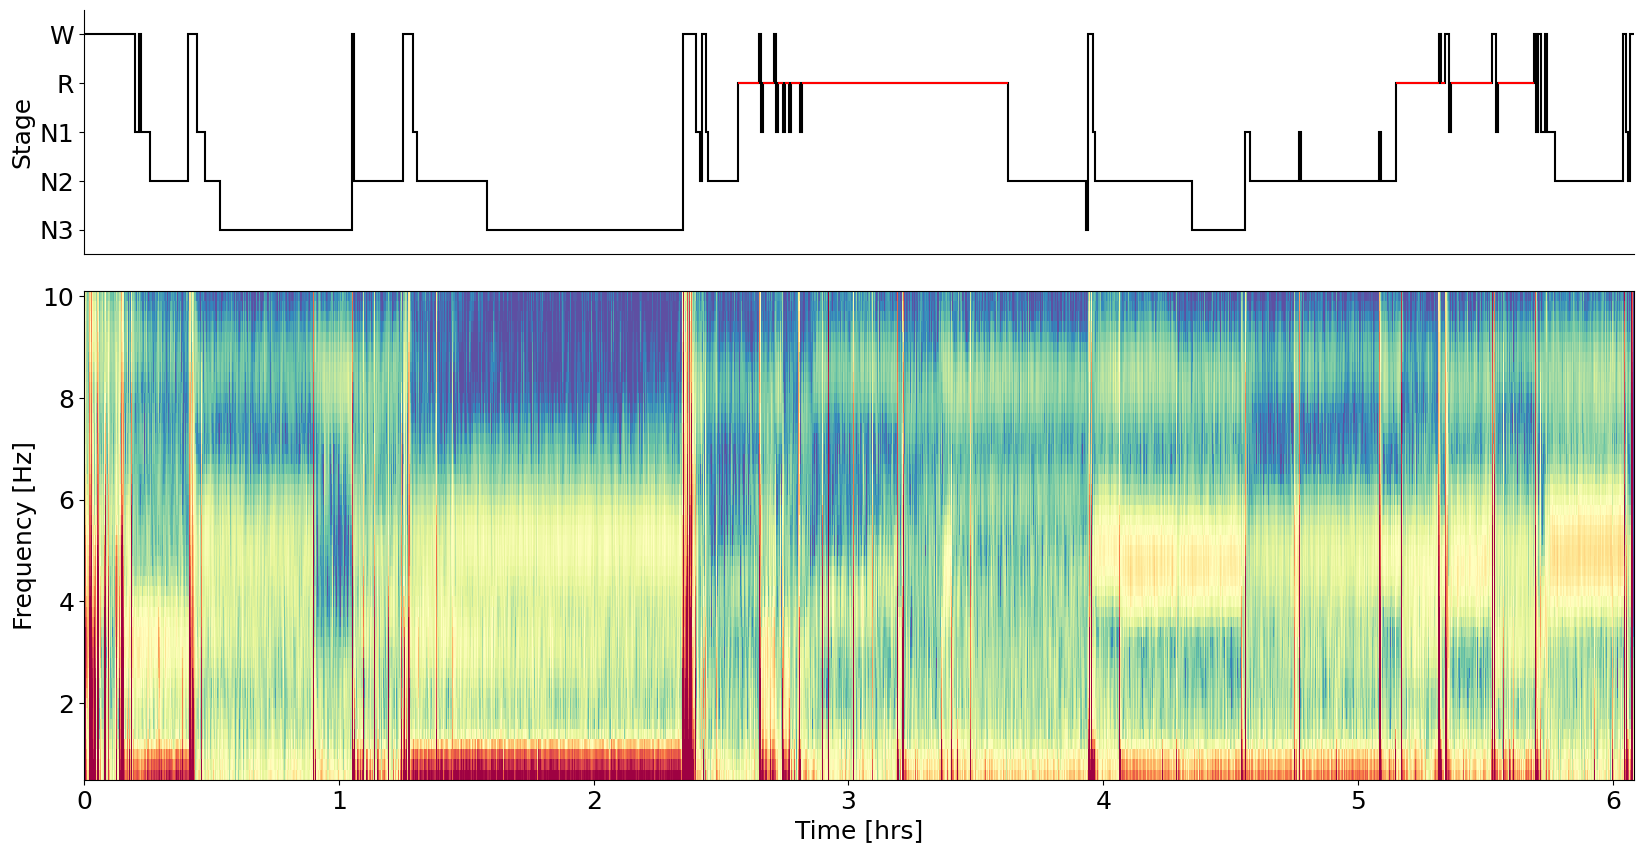

In [29]:
from scipy.signal import iirfilter, filtfilt
import numpy as np
x = np.load('sample/sample/accelerometer_x.npy')
start,end = 0,n_epoch
f = yasa.plot_spectrogram(x[30 * 50 * start:30 * 50 * end], 
                          50,
                          np.repeat(hypnogram[start:end],50 * 30), 
                          cmap='Spectral_r', win_sec = 5,trimperc = 2,fmax = 10)
f.set_figheight(10)
f.set_figwidth(20)


What do we see:
- Movement occured mainly during wake periods 
- Noisy signals during movement
- Low frequency power: N3 > N2 > N1-REM-Wake

## Visualisation of the spectral density of a few sleep epochs

As we have seen above, the frequency content of an EEG epoch is characterize pretty well a sleep stage.
We will now plot the power density over a sleep epoch.
1) We compute the STFT over 1000 points (4 seconds) for each epoch of 30 seconds

2) The magnitude of all the STFTs of an epoch (30 seconds) are averaged

3) We compute the density contained in each frequency band by dividing its power by the total power

4) We plot the density w.r.t the frequency

In [30]:
from scipy.signal import welch
from lspopt import spectrogram_lspopt


def get_average_spectrum_for_epochs(eeg,epochs):
    """
    Return the average power in each of the fourier bin for several epochs.
    """
    EEG_FS = 250
    psds = []
    for epoch in epochs:
        idx_start,idx_end = 250 * 30 * epoch,250 * 30 * (epoch + 1)
        freqs,t,psd = spectrogram_lspopt(np.clip(eeg[idx_start:idx_end],-150,150),250,nperseg = 1000)
        psds += [np.mean(np.abs(psd),1)]
    return freqs,np.array(psds).mean(0)


def plot_average_spectrum_for_epochs(eeg,epochs):
    """
    Compute and plot the power spectrum of a list of epochs
    """
    freqs,psd = get_average_spectrum_for_epochs(eeg,epochs)
    psd = psd/np.sum(psd)
    plt.plot(freqs, psd)
    plt.xlim(0, 18)
    plt.yscale('log')
    plt.ylim(1e-6,1)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Relative power')
    
    
def plot_average_spectrum_for_sleep_stage(eeg,hypnogram, sleep_stage):
    """
    Plot the average spectrum for all the sleep epochs of the provided sleep stage.
    """
    index = np.where(hypnogram == sleep_stage)[0]
    plot_average_spectrogram_for_epochs(eeg,index)

**On WAKE epoch, we can see a big bump of power in the alpha range**

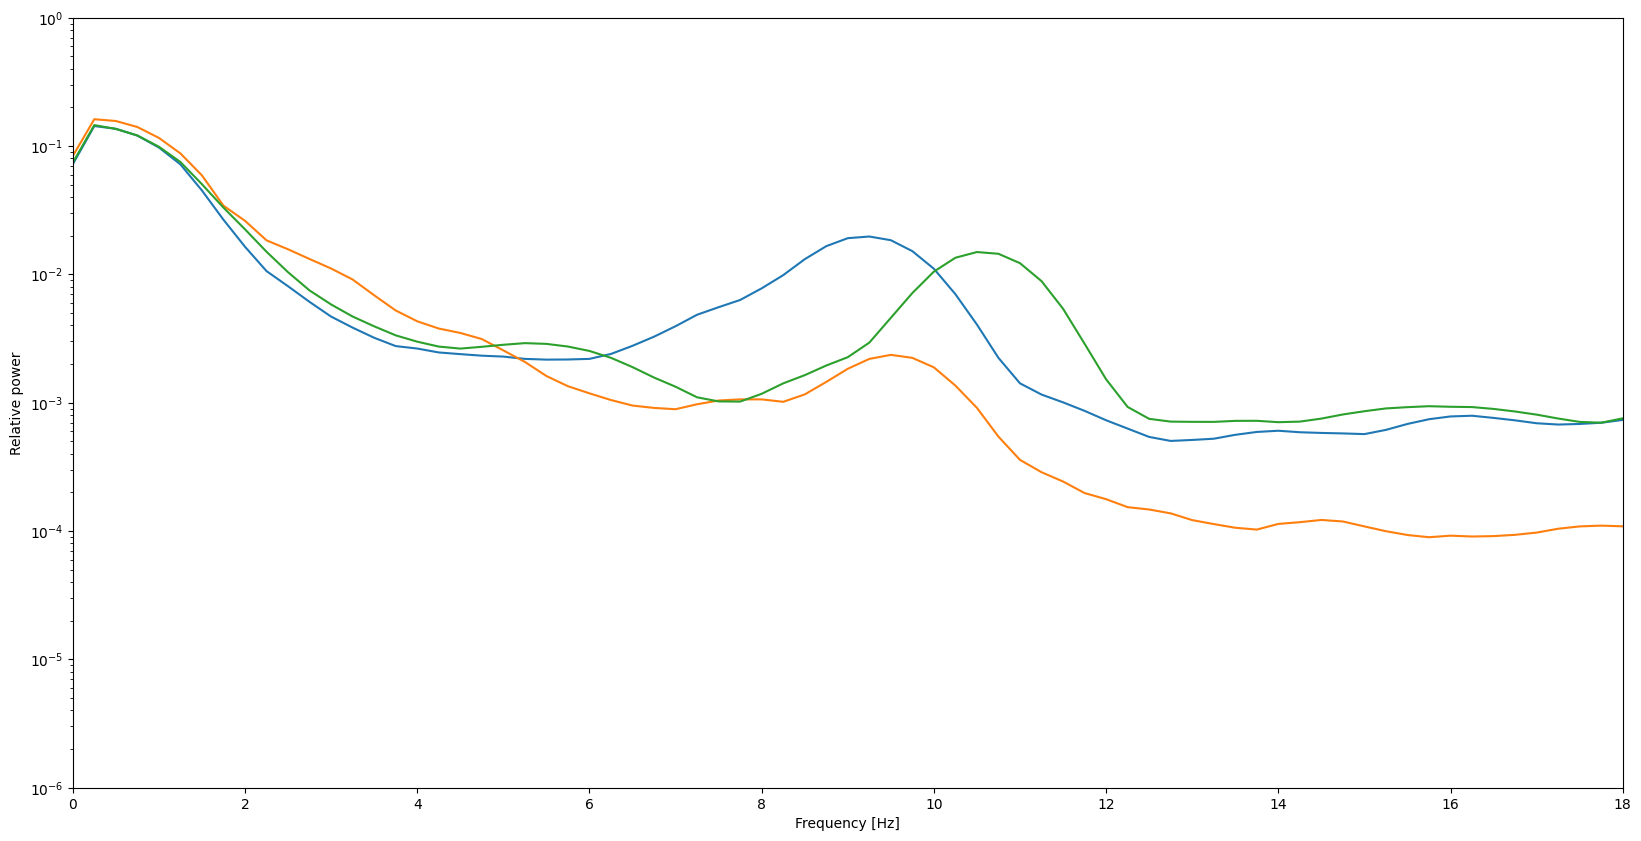

In [31]:
plot_average_spectrum_for_epochs(eeg,[685])
plot_average_spectrum_for_epochs(eeg,[688])
plot_average_spectrum_for_epochs(eeg,[20])

**On N3 epoch, we can see more power in the low frequencies and a longer tail**

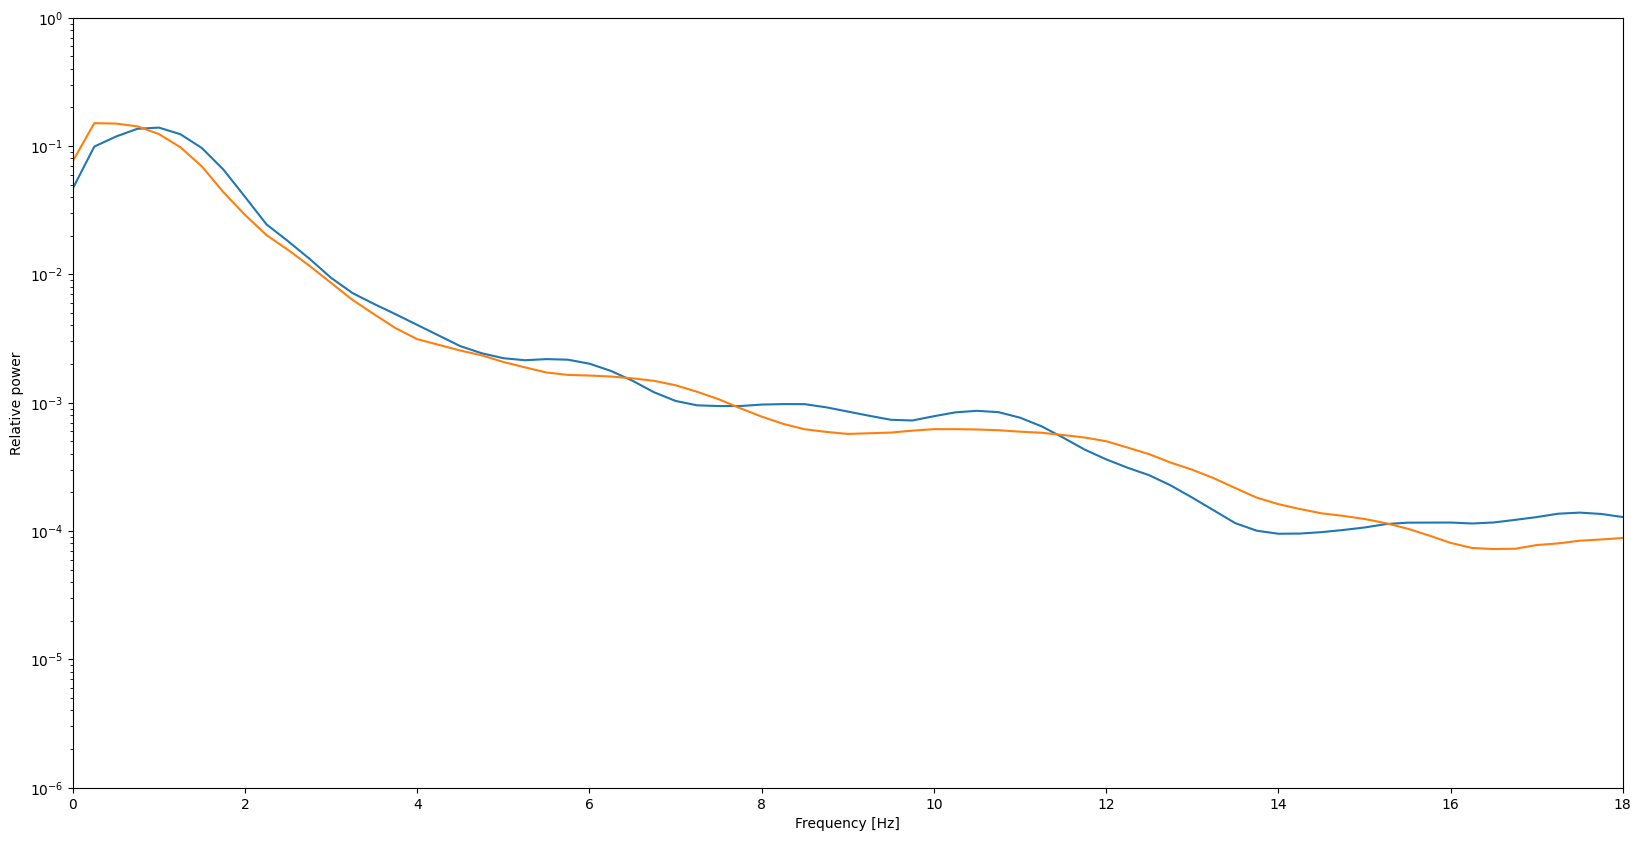

In [32]:
plot_average_spectrum_for_epochs(eeg,[90])
plot_average_spectrum_for_epochs(eeg_frontal,[90])


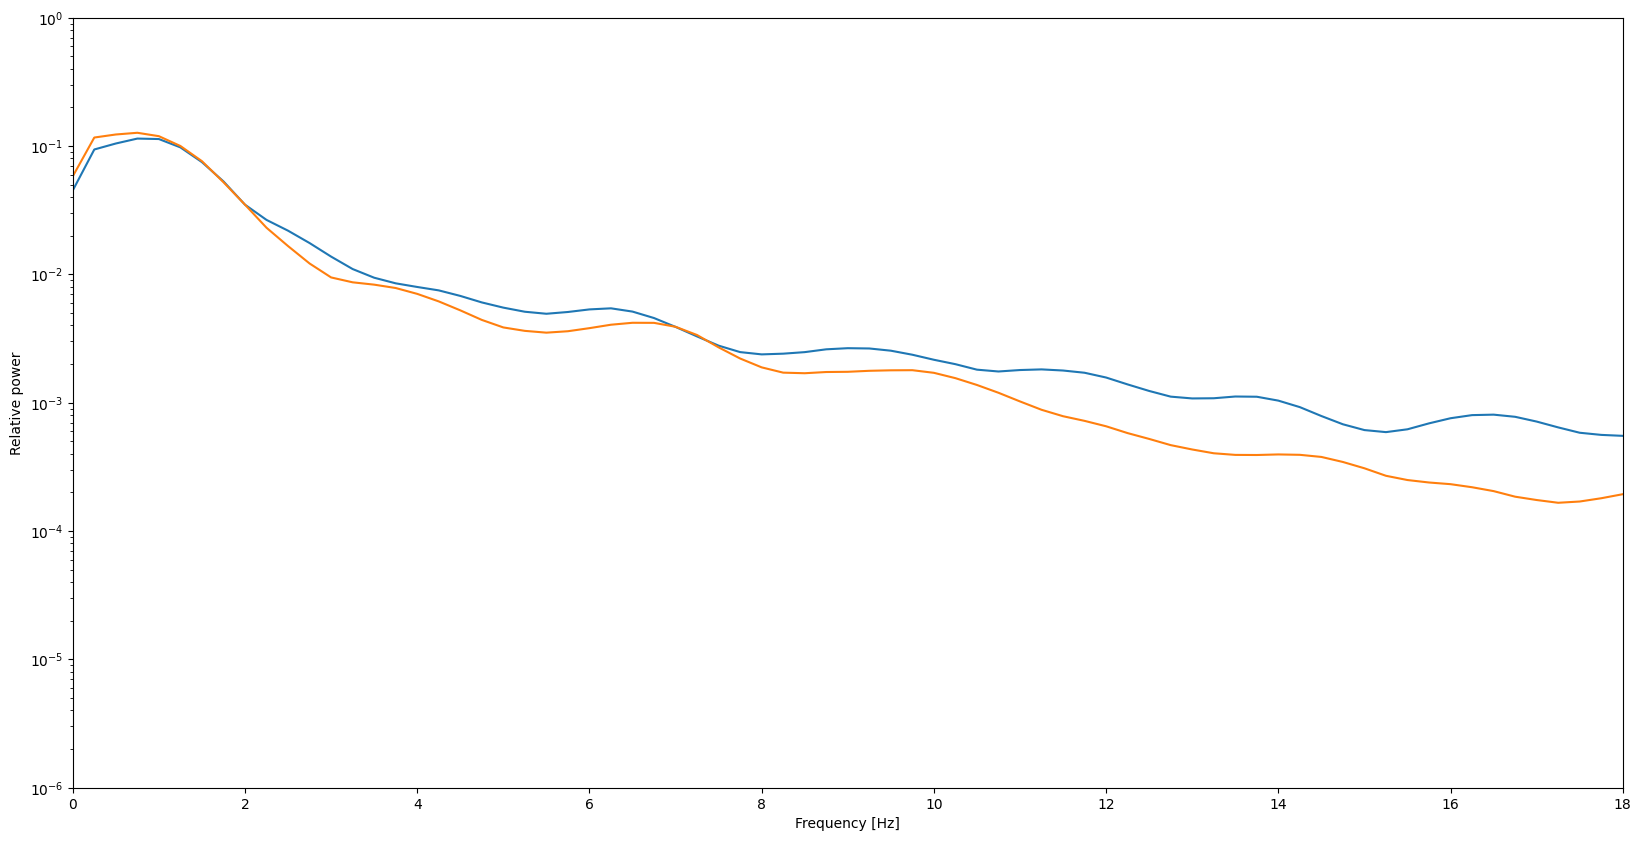

In [33]:
plot_average_spectrum_for_epochs(eeg,[202])
plot_average_spectrum_for_epochs(eeg_frontal,[202])

**On N2 epoch, power in the spindle range is much higher on frontal-frontal channels**

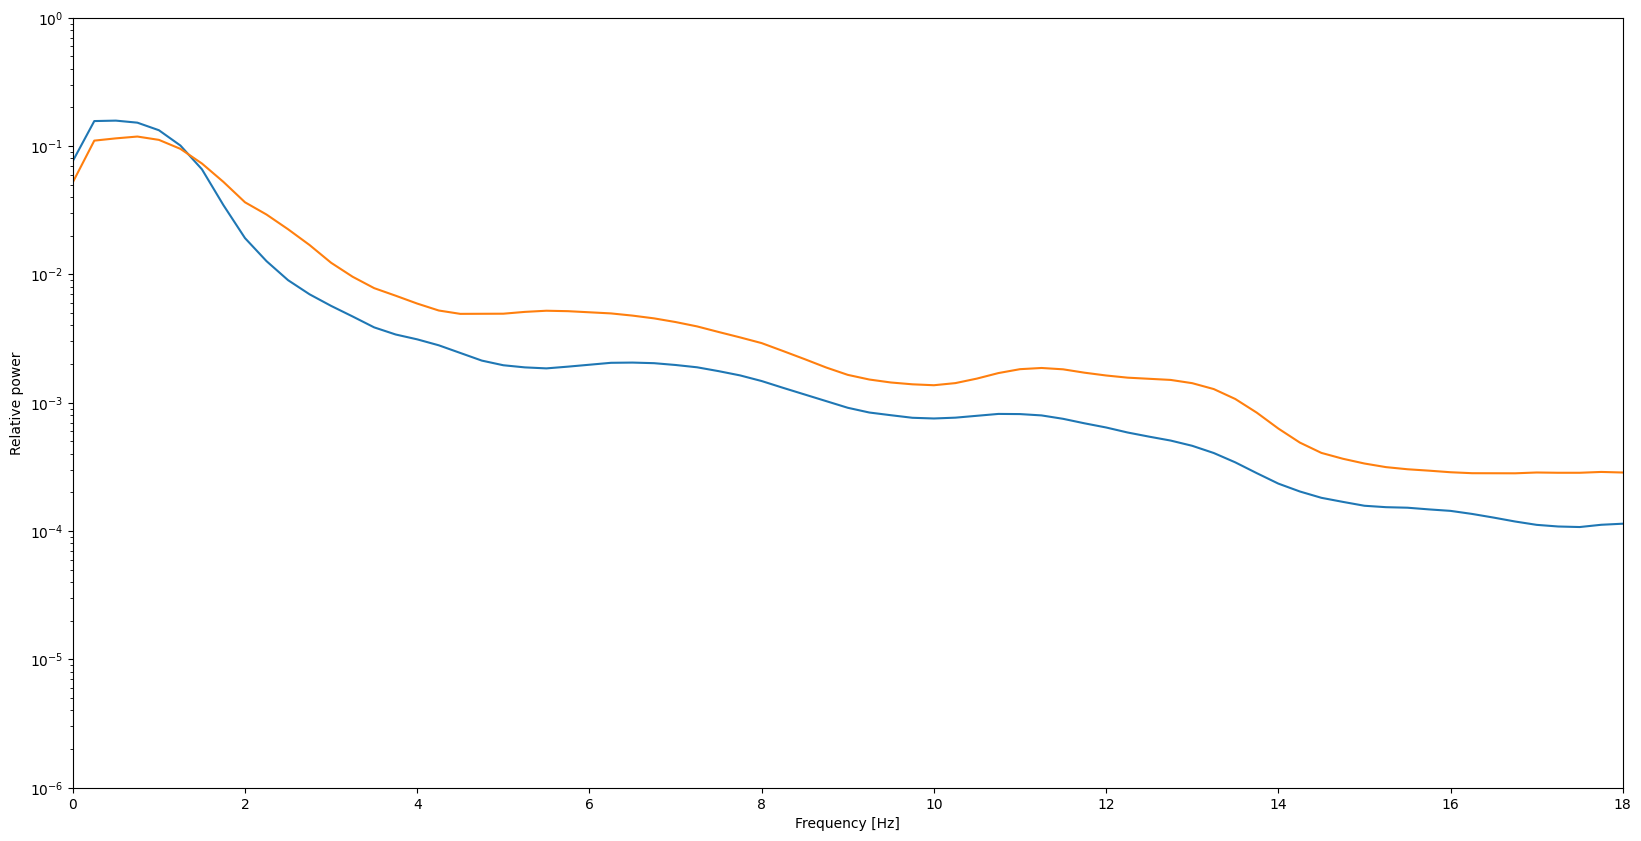

In [40]:
plot_average_spectrum_for_epochs(eeg,[510])
plot_average_spectrum_for_epochs(eeg_frontal,[510])

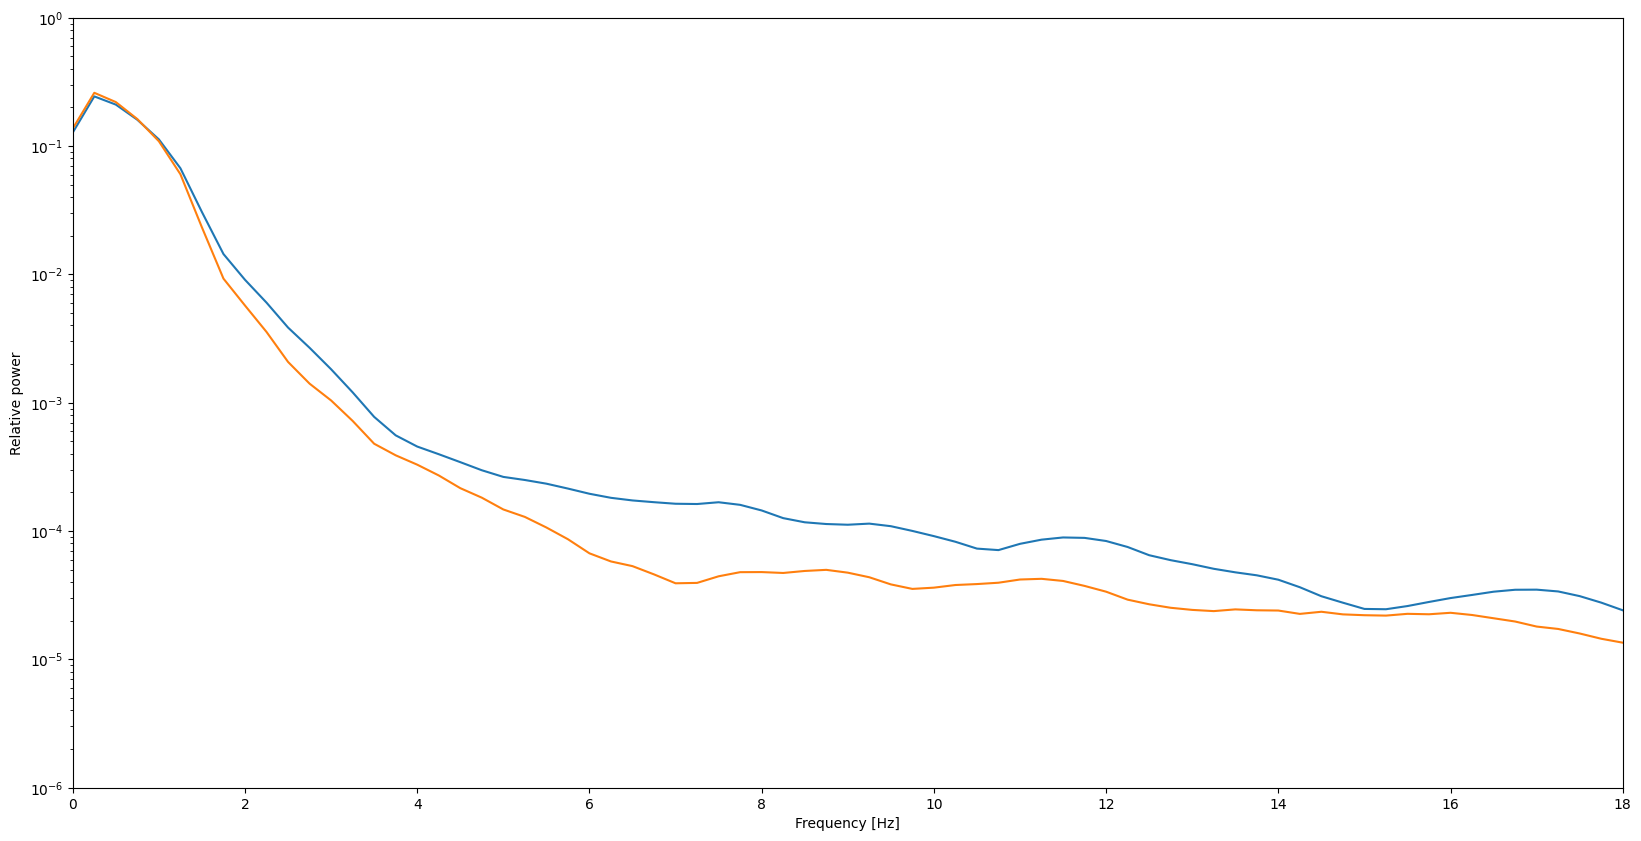

In [35]:
plot_average_spectrum_for_epochs(eeg,[711])
plot_average_spectrum_for_epochs(eeg_frontal,[711])


**REM epoch have more steady/flat power density**

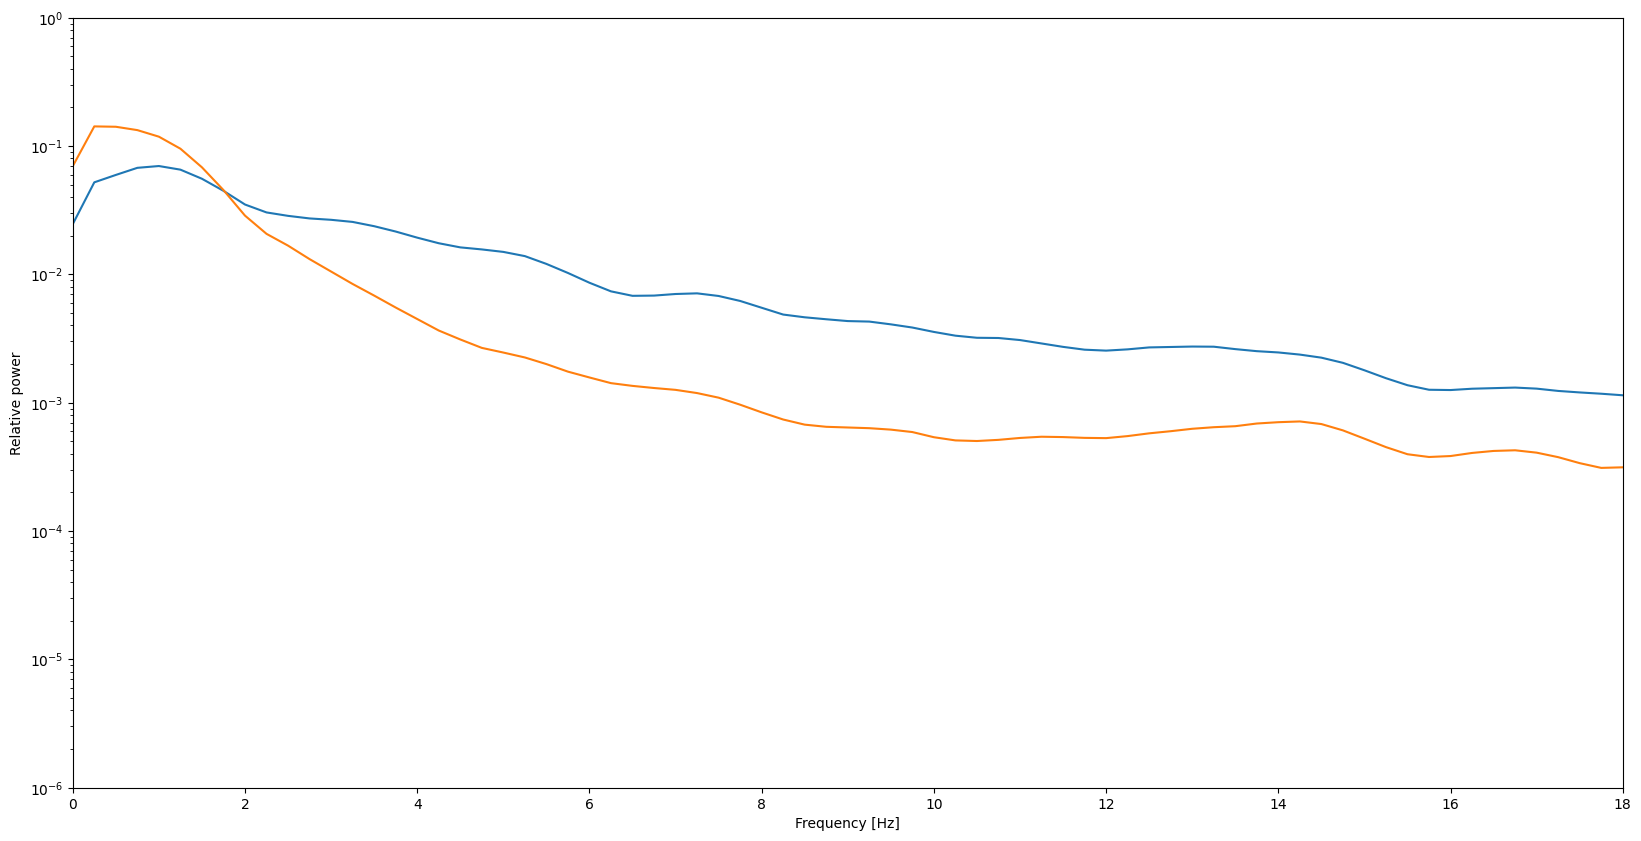

In [36]:
plot_average_spectrum_for_epochs(eeg,[405])
plot_average_spectrum_for_epochs(eeg_frontal,[405])

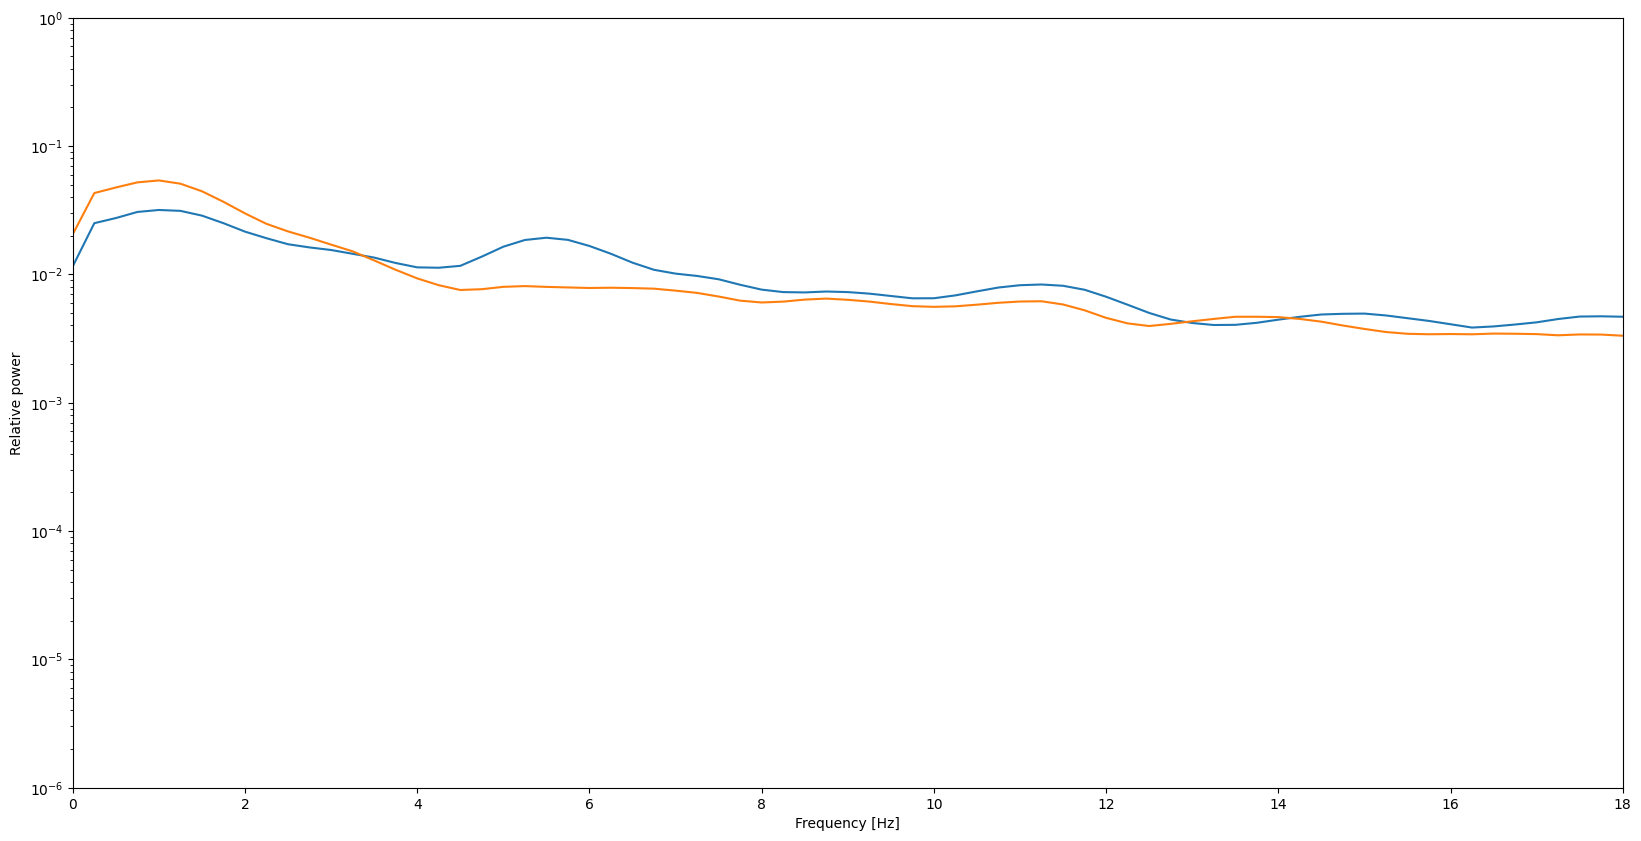

In [37]:
plot_average_spectrum_for_epochs(eeg,[837])
plot_average_spectrum_for_epochs(eeg_frontal,[837])

From these average spectrum graphs, can you find some rules to classify sleep stages ?

> Fill the *find_stage_from_spectrum* below.


In [38]:

# put your rules in this function
def find_stage_from_spectrum(spectrum, freq):
    # by default the value is -1
    stage = -1


    
    if 1:
        stage = 0
    elif 1: 
        stage = 1
    elif 1: 
        stage = 2
    elif 1: 
        stage = 3
    else:
        stage = 4

    return stage



Get your classification scores: this script uses your algorithm to predict sleep stages from the spectrogram of the record.

The scores are:
- Balanced accuracy: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html
- Cohen Kappa: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html#sklearn.metrics.cohen_kappa_score
- Confusion matrix: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix

In [39]:
predictions = []
for epoch in range(0,len(hypnogram)):
    freq,spectrum = get_average_spectrum_for_epochs(eeg,[epoch])
    prediction = find_stage_from_spectrum(spectrum,freq)
    predictions.append(prediction)

true_labels = hypnogram

# Get your scores
scores = {}
scores['balanced_accuracy'] = balanced_accuracy_score(true_labels, predictions)
scores['cohen_kappa'] = cohen_kappa_score(true_labels, predictions)
scores['confusion_matrix'] = confusion_matrix(true_labels, predictions)

print(scores)

{'balanced_accuracy': 0.2, 'cohen_kappa': 0.0, 'confusion_matrix': array([[ 58,   0,   0,   0,   0],
       [ 35,   0,   0,   0,   0],
       [279,   0,   0,   0,   0],
       [180,   0,   0,   0,   0],
       [178,   0,   0,   0,   0]], dtype=int64)}


## To practice

Exercise 1: For each of the channel from the sample record plot the data from t = 7200 seconds to t = 7300 seconds.

Exercise 2: Build a function to randomly plot the frontal frontal channels for N epochs from a specific sleep stage.

Exercise 3: Plot the evolution of the power in the delta band (0.5 to 4Hz) during the night.

Exercise 4: Plot the repartition of the power in the delta band (0.5 to 4Hz) for each of the sleep stage. Does an Anova reveal significant differences ?

As you see, it is not obvious to find rules to classify sleep stages automatically. It can take some times and there are too much patterns to take into account.

Thus, we are going to adress the machine learning methods in the next part.

Open the **Tutorial_Sleep_Staging_B.ipynb** tutorial
